<a href="https://colab.research.google.com/github/Damien-Cornuejouls/AIF-TPs/blob/main/INSA_inpainting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image denoising, inpainting and super-resolution with neural Networks

In this session, we will see different methods to improve images quality.  
In particular, we will use several architectures to remove noise, fill missing parts, and enhance the resolution of images.  
Let's begin with a straightforward toy example using the [FashionMNIST](https://github.com/zalandoresearch/fashion-mnist) dataset.

In [37]:
import torch
import torchvision
from torchvision import transforms
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader

In [38]:
train_dataset = FashionMNIST('data', train=True, download=True, transform=transforms.ToTensor())
test_dataset  = FashionMNIST('data', train=False, download=True, transform=transforms.ToTensor())
trainloader = DataLoader(train_dataset, batch_size=128, num_workers=2, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=128, num_workers=2, shuffle=True)

Here is a sample of images from the FashionMNIST dataset:

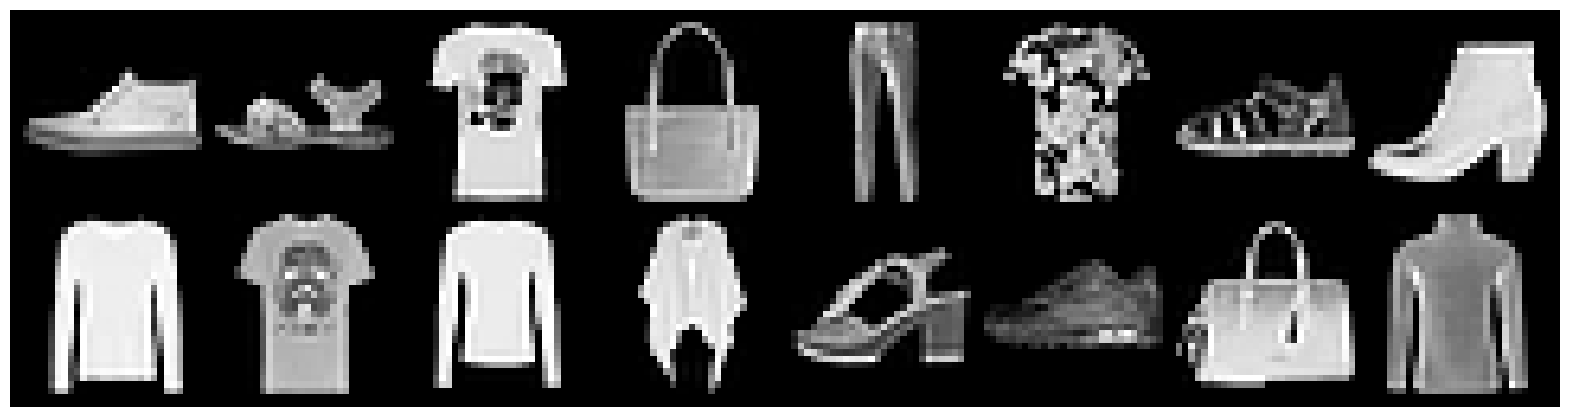

In [39]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

def plot_img(x):
    img_grid = make_grid(x[:16])
    plt.figure(figsize=(20,15))
    plt.imshow(img_grid.cpu().permute(1, 2, 0))
    plt.axis('off')
    plt.show()

x, _ = next(iter(trainloader))
plot_img(x)

Most of the methods we will use in these sessions are based on [auto-encoders](https://www.cs.toronto.edu/~hinton/science.pdf).  
An Autoencoder is a bottleneck architecture that turns a high-dimensional input into a latent low-dimensional code (encoder), and then reconstructs the input with this latent code (the decoder).  
![Source wikipedia](https://upload.wikimedia.org/wikipedia/commons/2/28/Autoencoder_structure.png)  
Let's define our first auto-encoder architecture:

In [40]:
import torch.nn as nn

class AutoEncoder(nn.Module):

    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            nn.ReLU(True)
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        z = self.encoder(x)
        y = self.decoder(z)
        return y

Verify that the defined architecture, outputs a tensor with the same dimensions as its inputs:

In [41]:
model = AutoEncoder()
y = model(x)
print(f'Input shape: {x.shape}')
print(f'Reconstruction shape: {y.shape}')

Input shape: torch.Size([128, 1, 28, 28])
Reconstruction shape: torch.Size([128, 1, 28, 28])


We will train our auto-encoder to minimize an MSE loss between pixels of the original inputs and the reconstrictions.  
Fill the following code to define the training method of our auto-encoder.  

In [42]:
from tqdm.notebook import tqdm
from statistics import mean

def train(net, optimizer, loader, epochs=5, noise_factor=0.3):
    criterion = torch.nn.MSELoss()
    for epoch in range(epochs):
        running_loss = []
        t = tqdm(loader) #for progress bar
        for x, _ in t:
            x = x.to(device) #set x on GPU or CPU
            x_hat = net(x) # Get models reconstruction
            loss = criterion(x_hat, x)
            running_loss.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            t.set_description(f'training loss: {mean(running_loss)}')
        plot_img(x[:8]) #plot original image
        plot_img(torch.clip(x_hat[:8], 0, 1)) #plot reconstruction

Now let's train our first auto-encoder:

  0%|          | 0/469 [00:00<?, ?it/s]

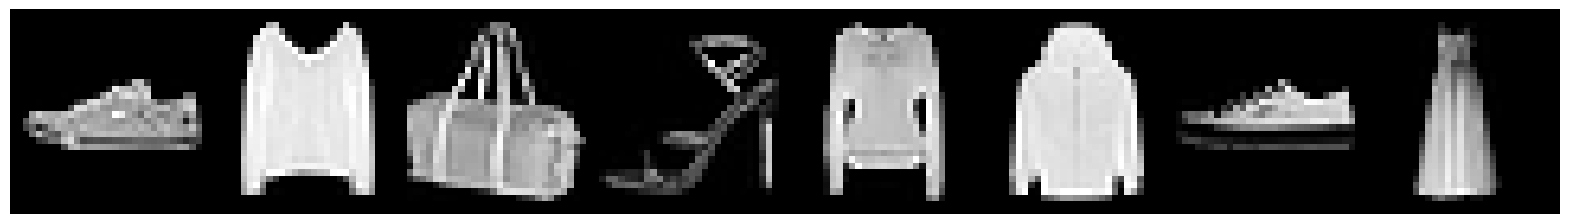

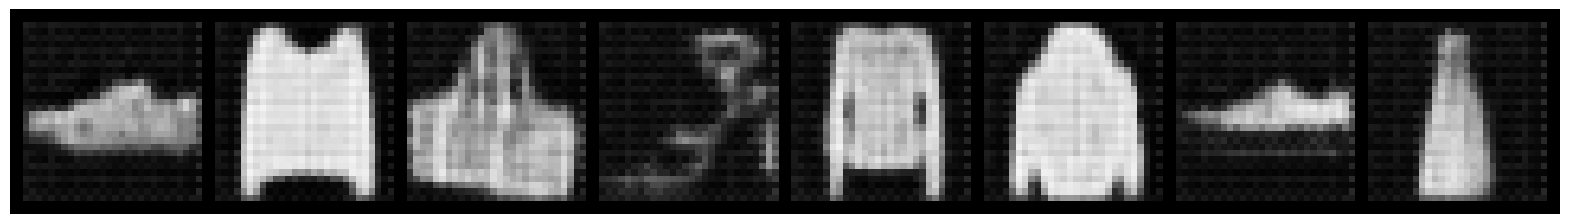

  0%|          | 0/469 [00:00<?, ?it/s]

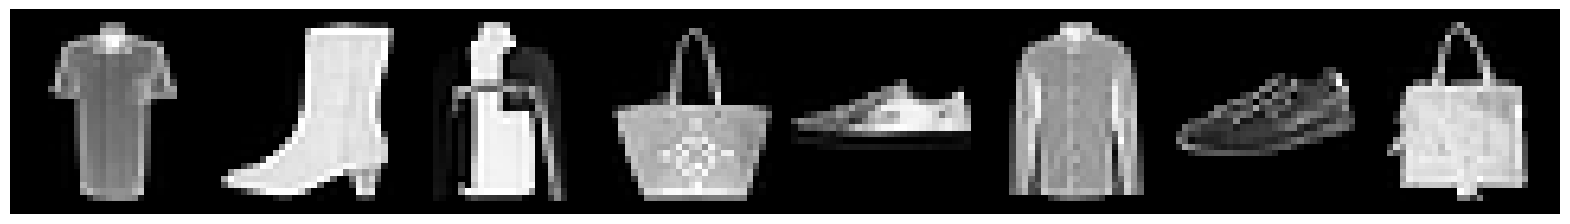

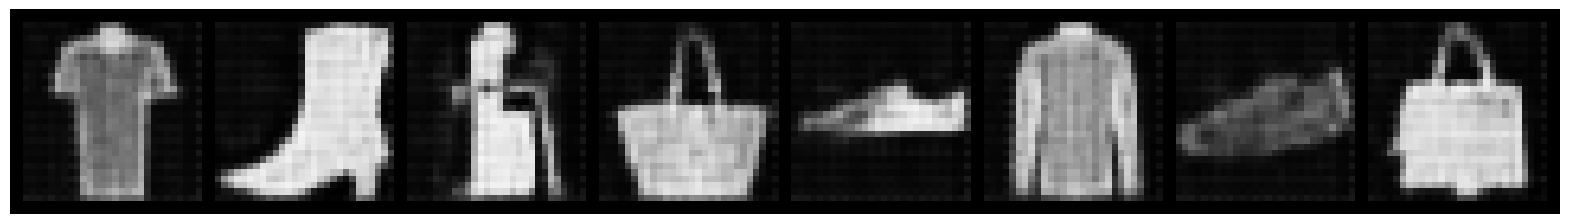

  0%|          | 0/469 [00:00<?, ?it/s]

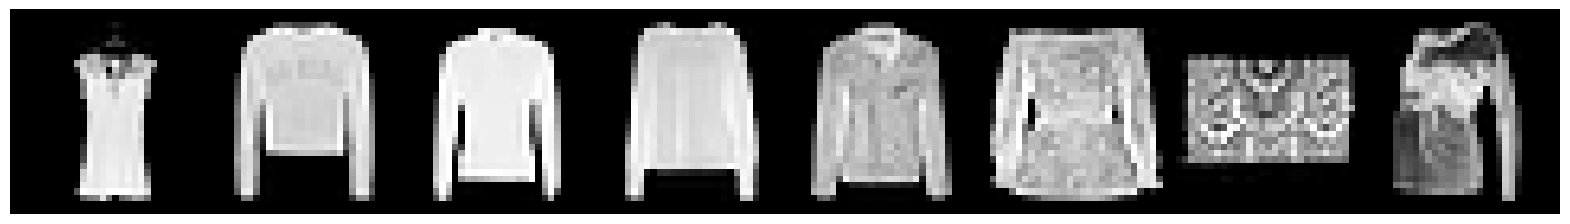

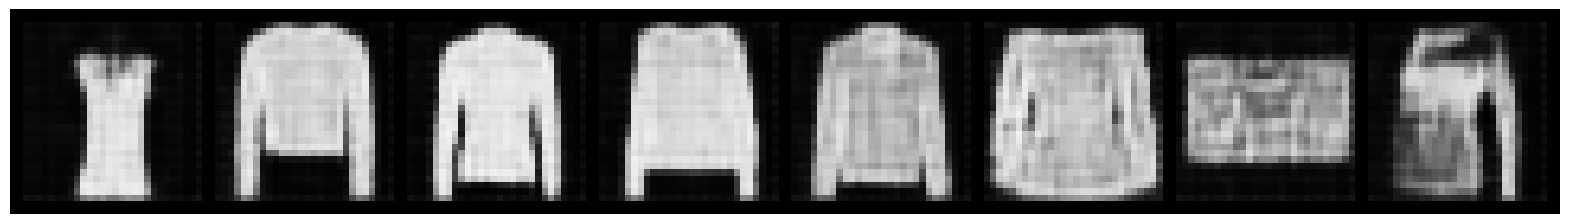

  0%|          | 0/469 [00:00<?, ?it/s]

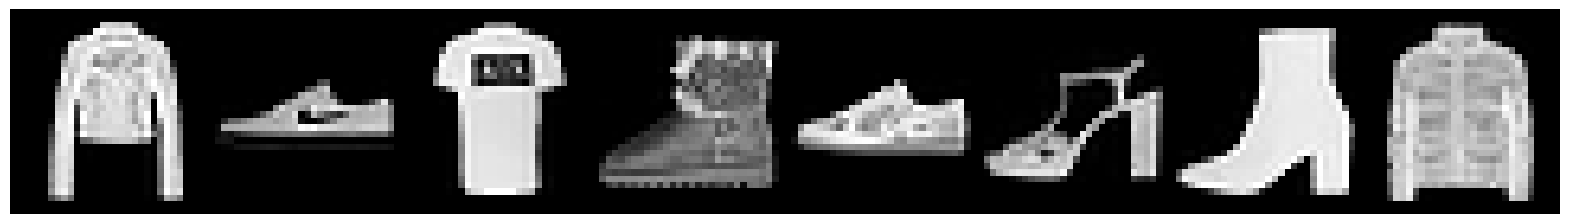

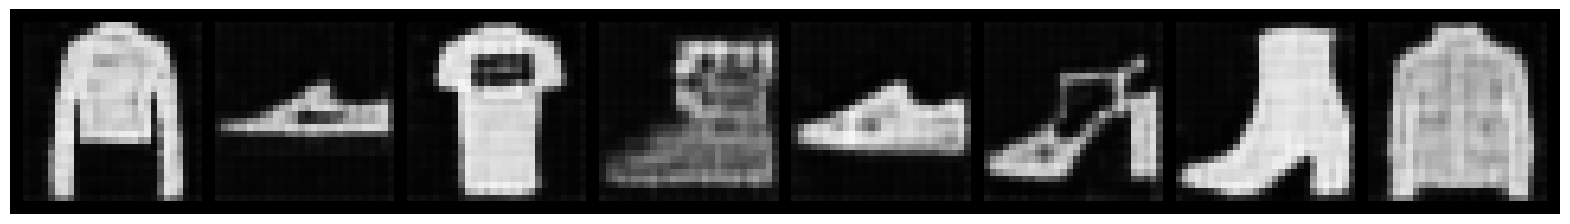

  0%|          | 0/469 [00:00<?, ?it/s]

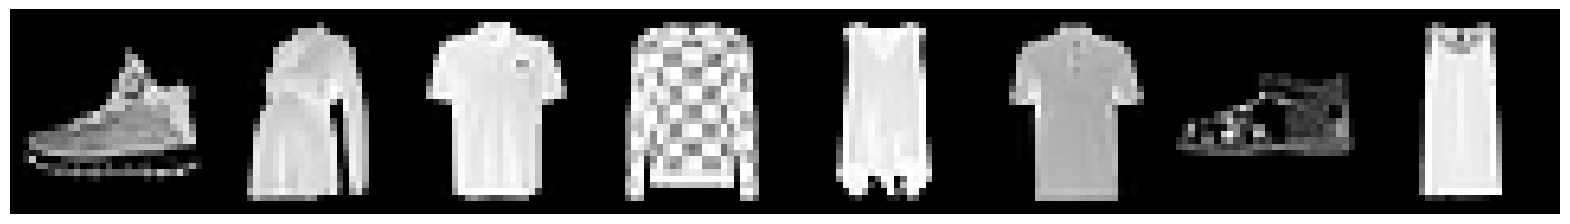

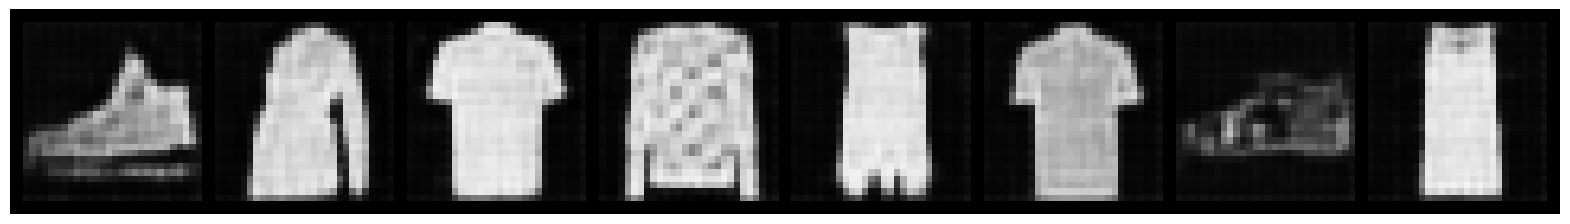

In [43]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = AutoEncoder().to(device)#set the model on GPU or CPU
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0.001)
train(model, optimizer, trainloader, epochs=5)

## Denoising Auto-encoder:

Auto-encoders are a simple and yet powerful way to remove noises.  
Fill the following method to add a gaussian noise to our input images and train a denoising auto-encoder to reconstruct images without noise.


In [48]:
def add_noise(inputs,noise_factor=0.3):
    noisy = inputs+torch.randn_like(inputs) * noise_factor
    noisy = torch.clip(noisy,0.,1.)
    return noisy

def train_denoising(net, optimizer, loader, epochs=5, noise_factor=0.3):
    criterion = torch.nn.MSELoss()
    for epoch in range(epochs):
        running_loss = []
        t = tqdm(loader)
        for x, _ in t:
            x = x.to(device)
            x_noise = x + torch.randn_like(x) * noise_factor
            x_noise = torch.clip(x_noise, 0, 1).to(device)
            outputs = net(x_noise)
            loss = criterion(outputs, x_noise)
            running_loss.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            t.set_description(f'training loss: {mean(running_loss)}')
        plot_img(x[:8])
        plot_img(x_noise[:8])
        plot_img(torch.clip(outputs[:8], 0, 1))

In [ ]:
#@title Solution
def add_noise(inputs,noise_factor=0.3):
    noisy = inputs+torch.randn_like(inputs) * noise_factor
    noisy = torch.clip(noisy,0.,1.)
    return noisy

def train_denoising(net, optimizer, loader, epochs=5, noise_factor=0.3):
    criterion = torch.nn.MSELoss()
    for epoch in range(epochs):
        running_loss = []
        t = tqdm(loader)
        for x, _ in t:
            x = x.to(device)
            x_noise = add_noise(x,noise_factor)
            outputs = net(x_noise)
            loss = criterion(outputs, x)
            running_loss.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            t.set_description(f'training loss: {mean(running_loss)}')
        plot_img(x[:8])
        plot_img(x_noise[:8])
        plot_img(torch.clip(outputs[:8], 0, 1))

  0%|          | 0/469 [00:00<?, ?it/s]

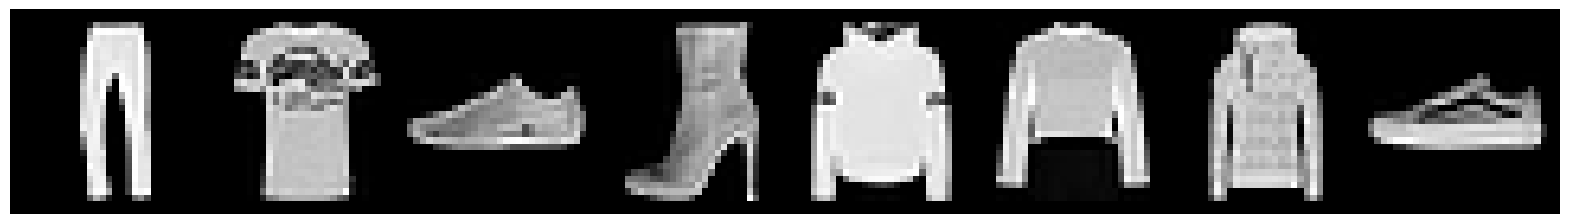

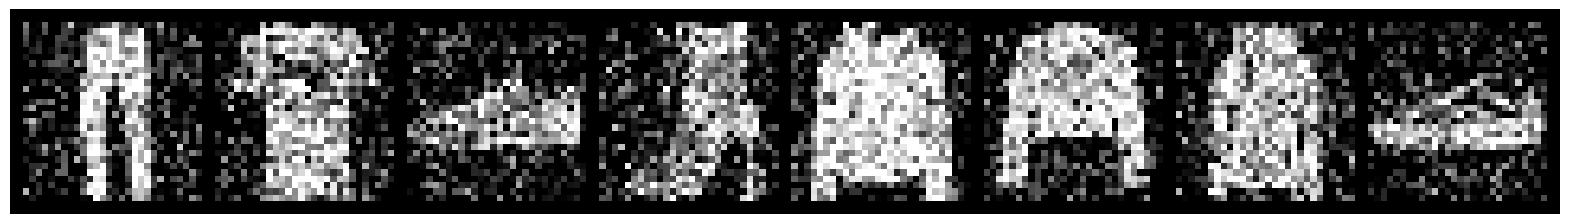

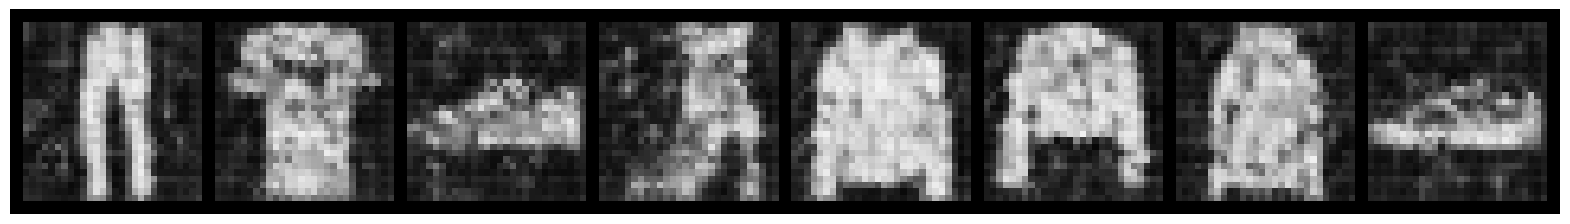

  0%|          | 0/469 [00:00<?, ?it/s]

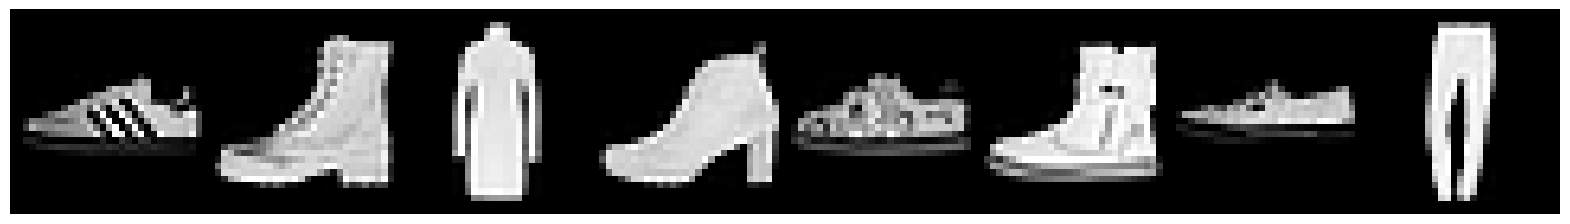

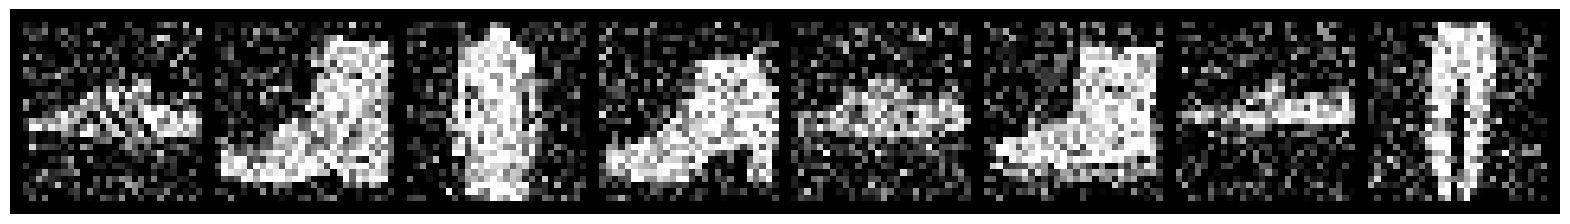

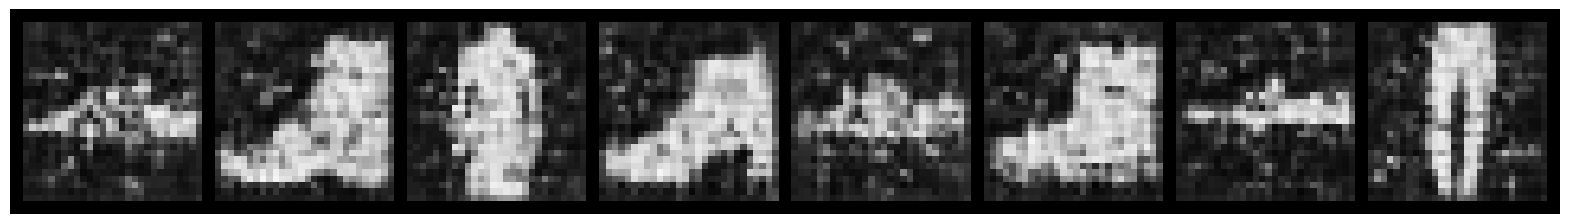

  0%|          | 0/469 [00:00<?, ?it/s]

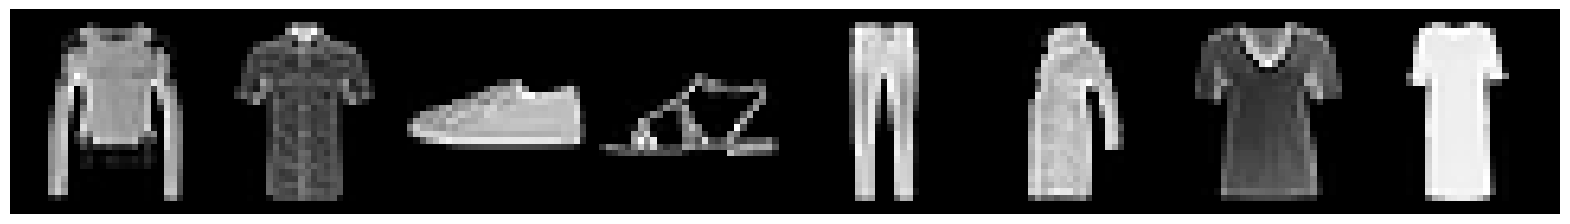

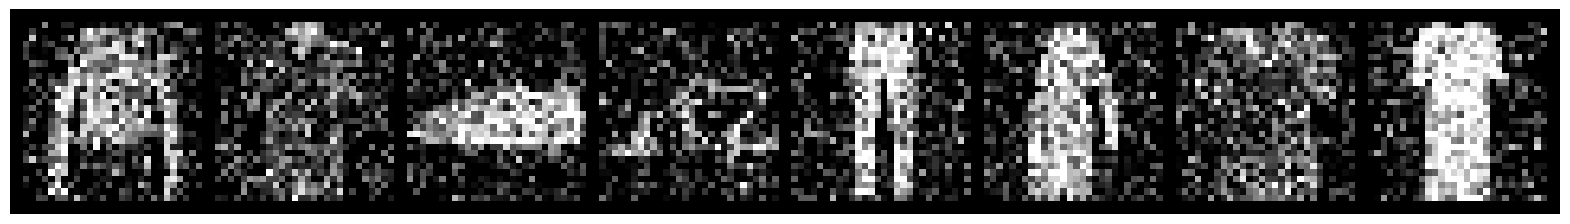

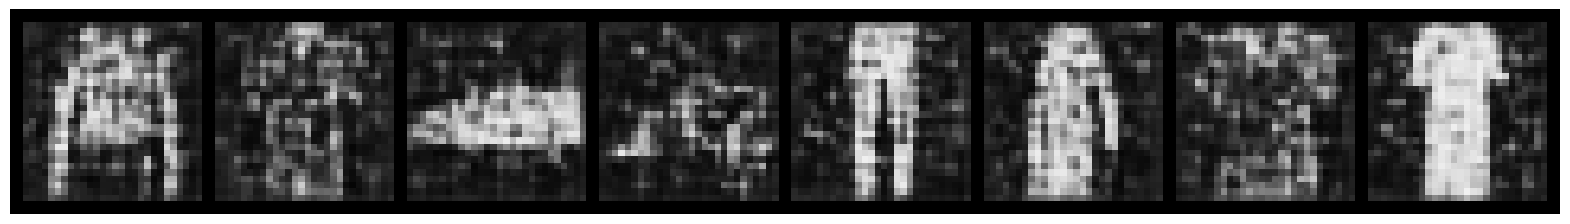

  0%|          | 0/469 [00:00<?, ?it/s]

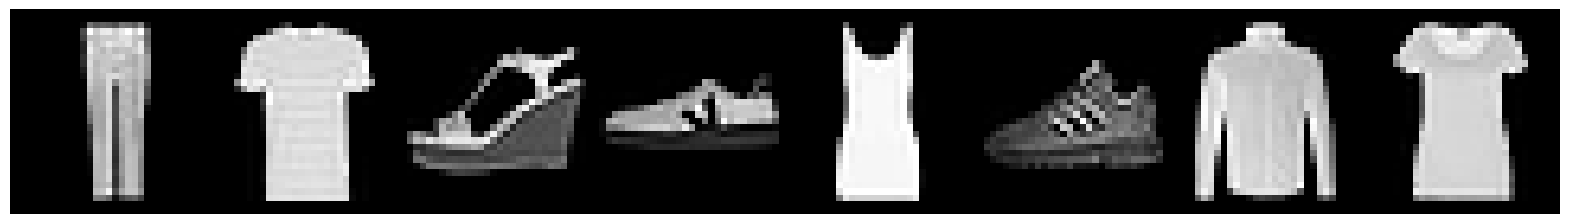

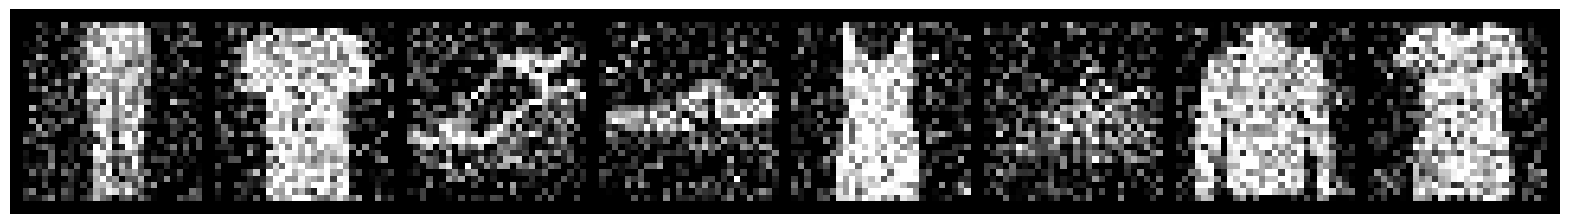

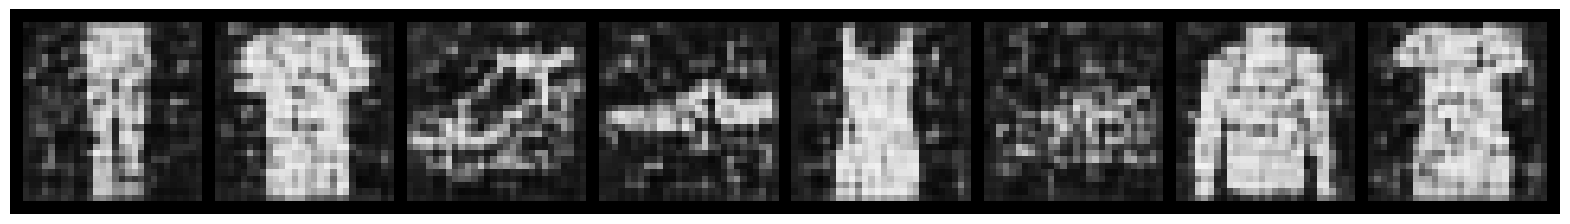

  0%|          | 0/469 [00:00<?, ?it/s]

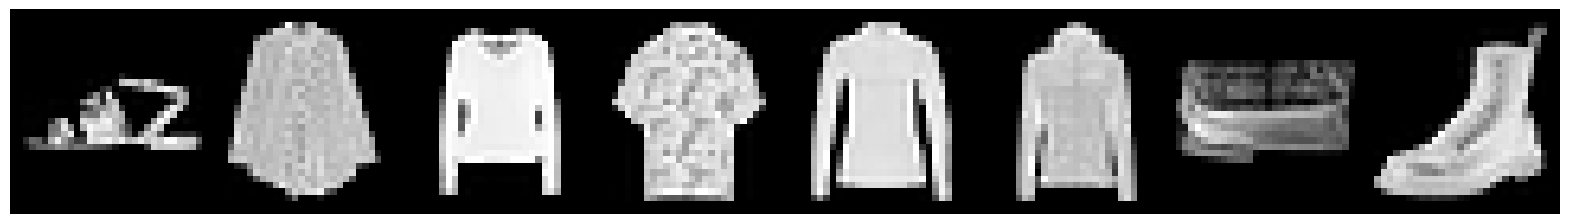

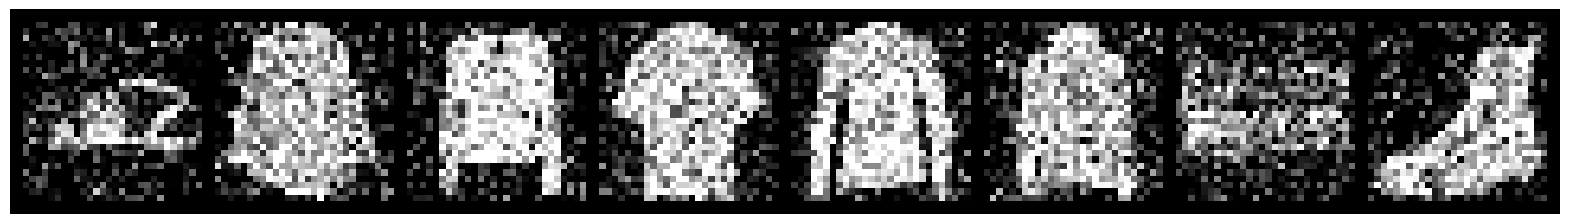

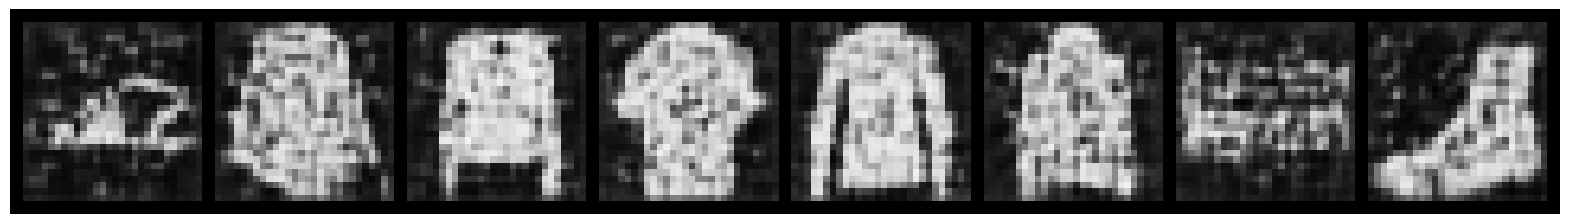

In [49]:
model = AutoEncoder().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0.001)
train_denoising(model, optimizer, trainloader, epochs=5)

## Super-Resolution

Following the same principle, we can use auto-encoders for other image processing tasks such as resolution enhancement or image inpainting.  
Let's use an auto-encoder to enhance the resolution of an image.  
We will generate low-resolution images using a pooling layer and train an auto-encoder to reconstruct the images in the original resolution.  
Complete the following code to train a super-resolution auto-encoder.

In [50]:
def downscale(x, scale_factor=2, upscale=True):
    x_low = torch.nn.MaxPool2d(kernel_size=scale_factor)(x)
    if upscale:
        x_low = torch.nn.Upsample(scale_factor=scale_factor, mode='bilinear', align_corners=True)(x_low)
    return x_low

In [56]:
def train_upscale(net, optimizer, loader, epochs=5, scale_factor=2, upscale=True):
    criterion = torch.nn.MSELoss()
    for epoch in range(epochs):
        running_loss = []
        t = tqdm(loader)
        for x, _ in t:
            x = x.to(device)
            x_low_res = downscale(x, scale_factor, upscale)
            x_hat = net(x_low_res)
            loss = criterion(x_hat, x)
            running_loss.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            t.set_description(f'training loss: {mean(running_loss)}')
        plot_img(x[:8])
        plot_img(x_low_res[:8])
        plot_img(torch.clip(x_hat[:8], 0, 1))

In [ ]:
#@title Solution
def train_upscale(net, optimizer, loader, epochs=5, scale_factor=2, upscale=True):
    criterion = torch.nn.MSELoss()
    for epoch in range(epochs):
        running_loss = []
        t = tqdm(loader)
        for x, _ in t:
            x = x.to(device)
            x_low_res = downscale(x, scale_factor, upscale)
            x_hat = net(x_low_res)
            loss = criterion(x_hat, x)
            running_loss.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            t.set_description(f'training loss: {mean(running_loss)}')
        plot_img(x[:8])
        plot_img(x_low_res[:8])
        plot_img(torch.clip(x_hat[:8], 0, 1))

  0%|          | 0/469 [00:00<?, ?it/s]

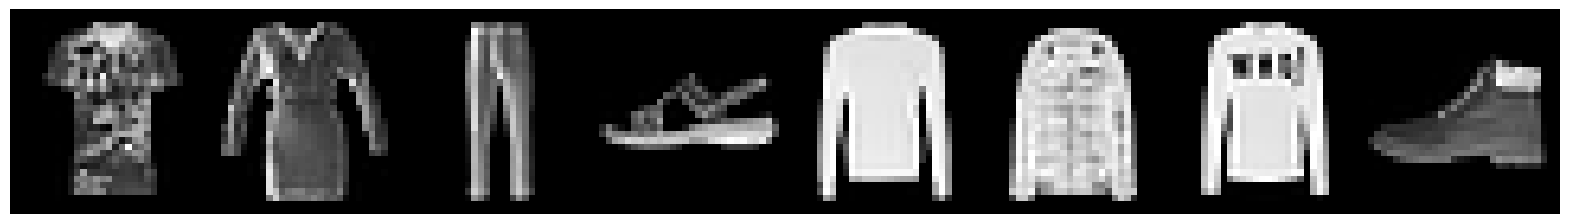

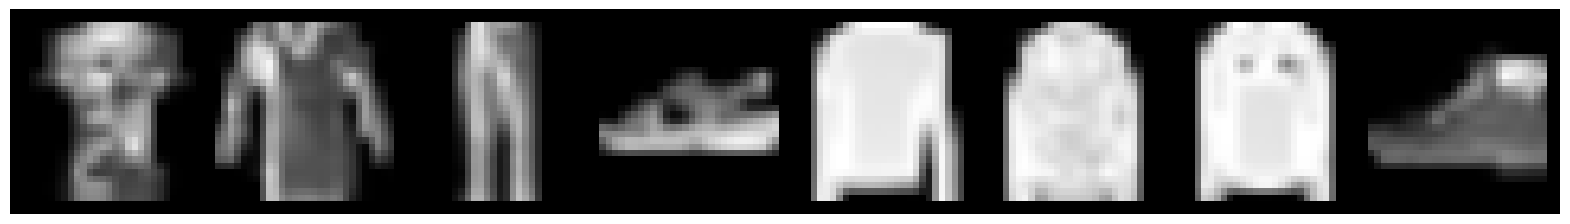

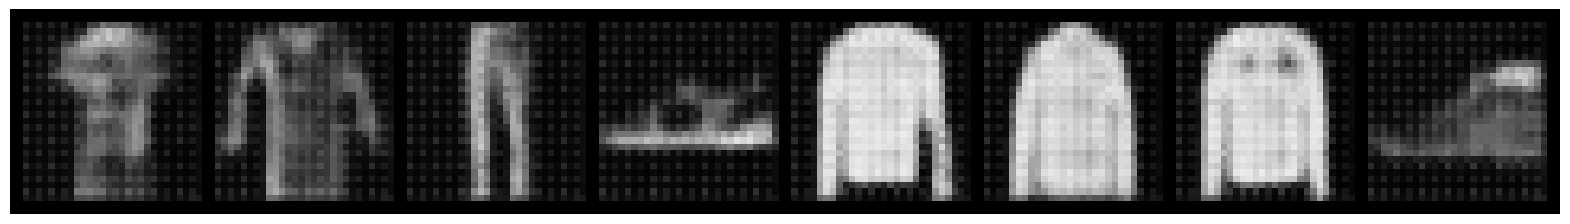

  0%|          | 0/469 [00:00<?, ?it/s]

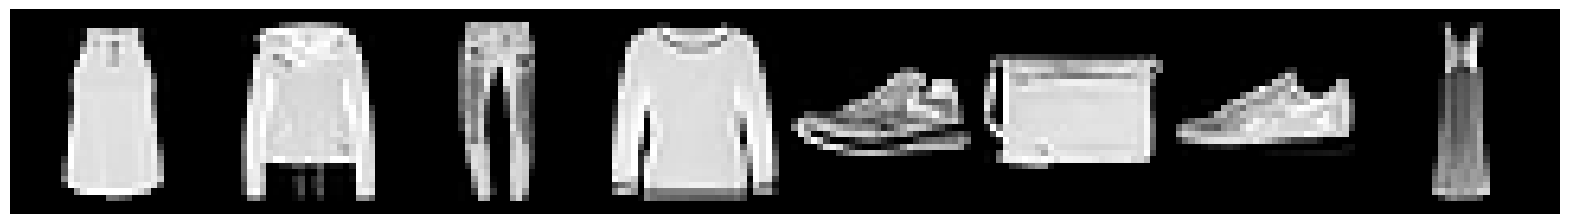

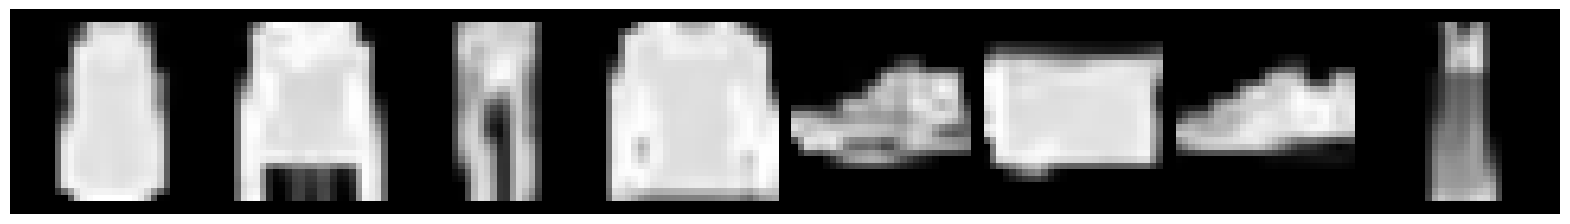

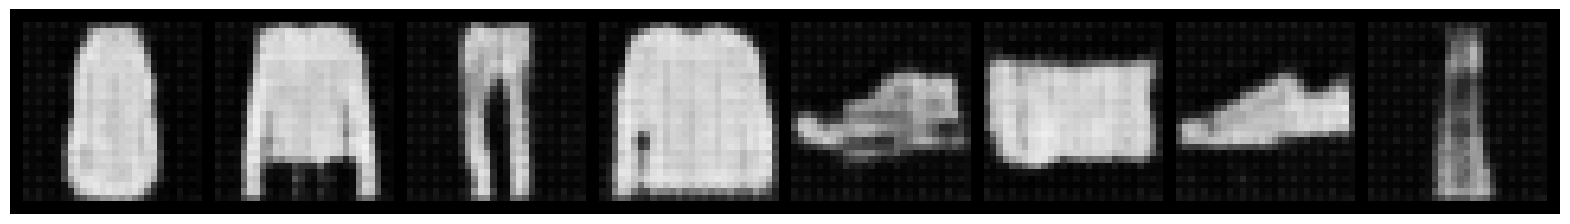

  0%|          | 0/469 [00:00<?, ?it/s]

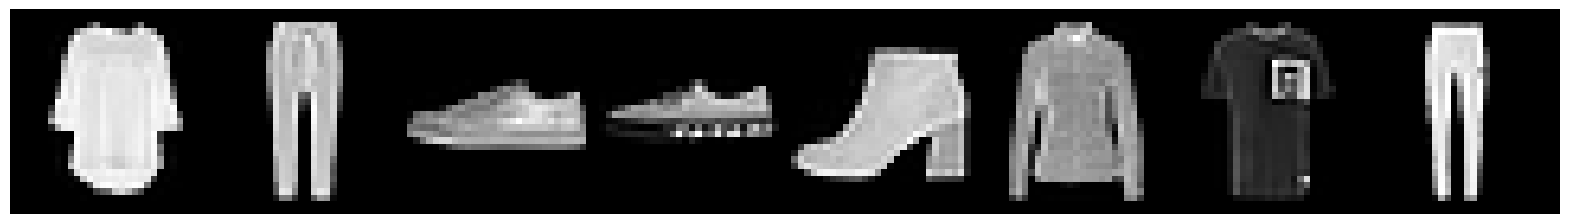

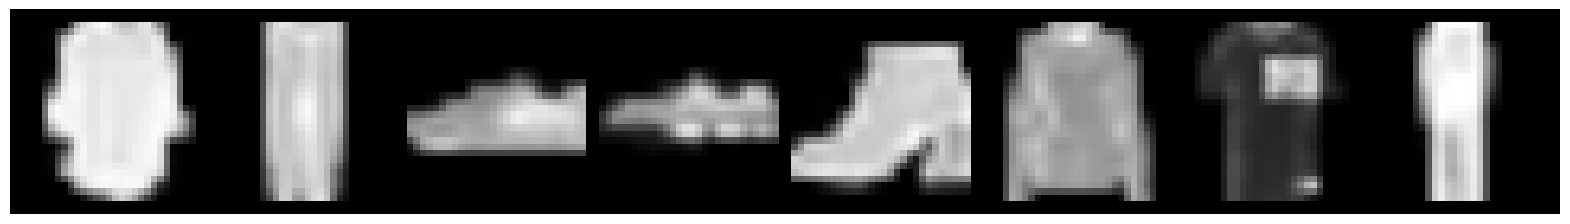

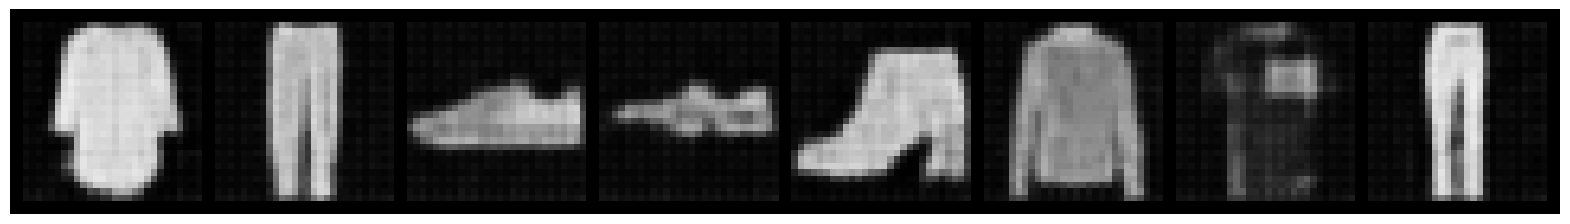

  0%|          | 0/469 [00:00<?, ?it/s]

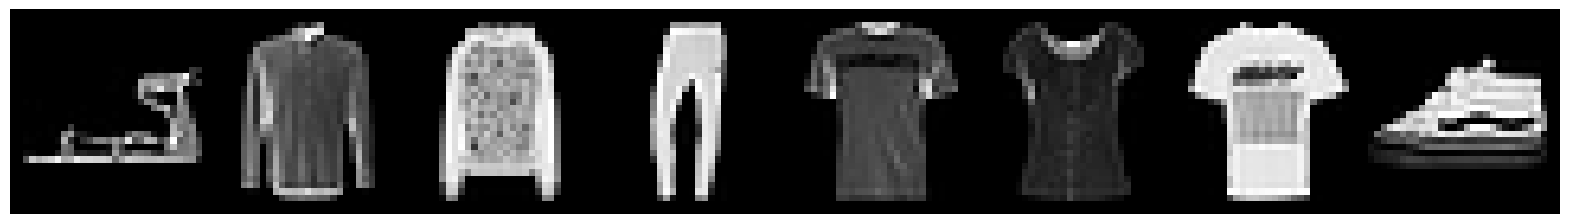

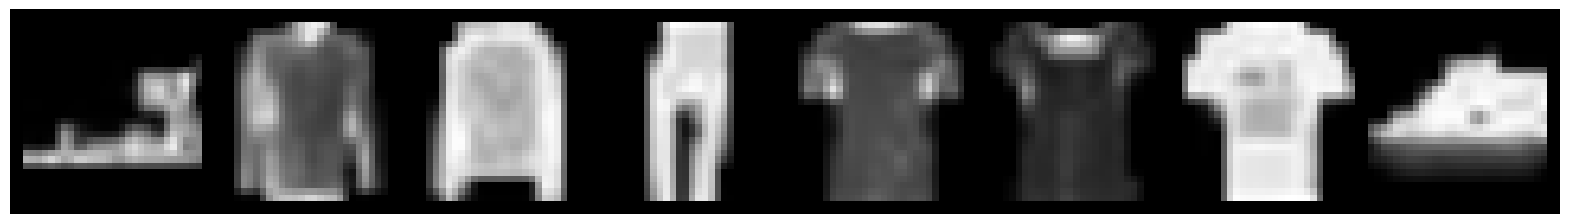

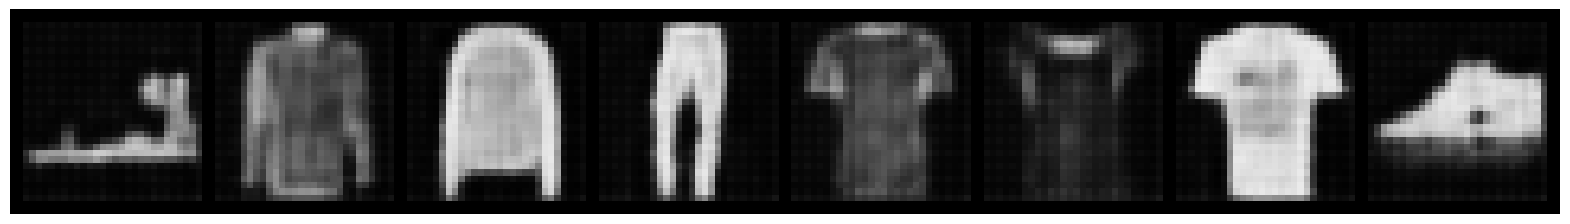

  0%|          | 0/469 [00:00<?, ?it/s]

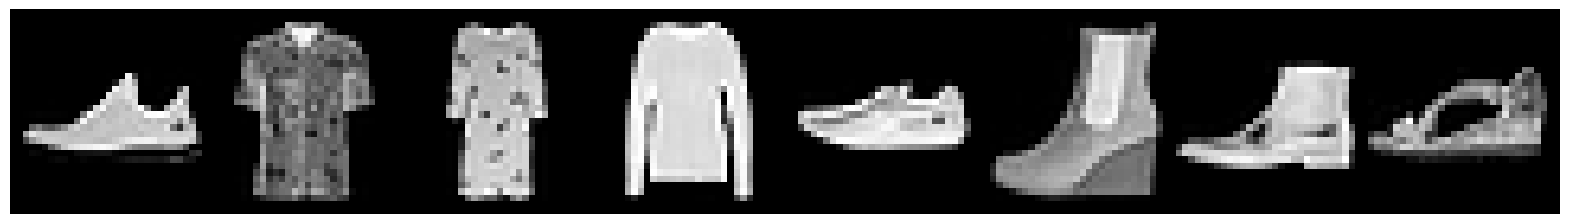

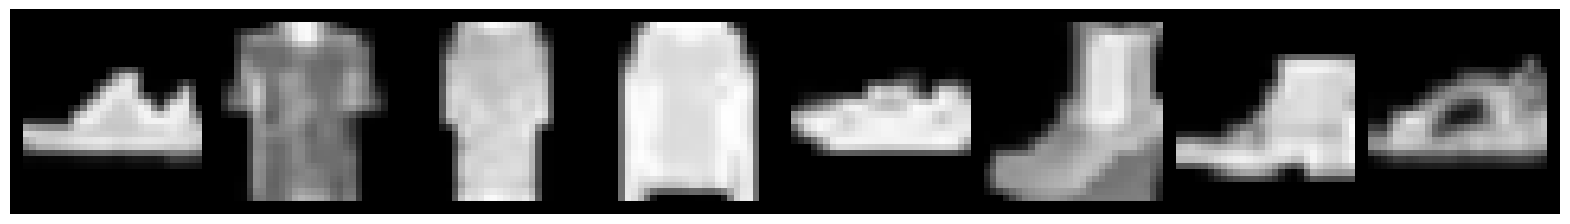

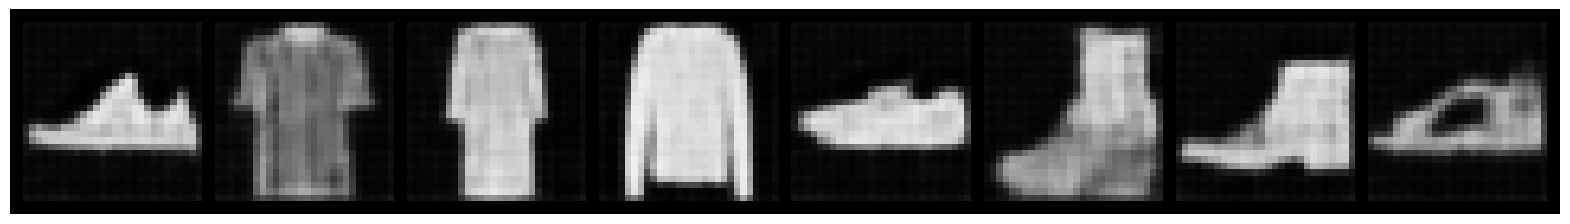

In [57]:
model = AutoEncoder().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0.001)
train_upscale(model, optimizer, trainloader, epochs=5)

## Inpainting

The following function returns a image with missing parts.  
Use it to train an auto-encoder on image inpainting.

In [53]:
import numpy as np

def random_cutout(imgs, min_cut=15,max_cut=45):
    n, c, h, w = imgs.shape
    w1 = np.random.randint(min_cut, max_cut, n)
    h1 = np.random.randint(min_cut, max_cut, n)

    w2 = np.random.randint(min_cut, max_cut, n)
    h2 = np.random.randint(min_cut, max_cut, n)

    cutouts = torch.empty((n, c, h, w), dtype=imgs.dtype, device=imgs.device)
    for i, (img, w11, h11, w22, h22) in enumerate(zip(imgs, w1, h1, w2, h2)):
        cut_img = img.clone()
        cut_img[:, h11:h11 + h11, w11:w11 + w11] = 0
        cut_img[:, h22:h22 + h11, w22:w22 + w22] = 0
        cutouts[i] = cut_img
    return cutouts

In [58]:
def train_inpainting(net, optimizer, loader, epochs=5, min_cut=15,max_cut=45):
    criterion = torch.nn.MSELoss()
    for epoch in range(epochs):
        running_loss = []
        t = tqdm(loader)
        for x, _ in t:
            x = x.to(device)
            x_cut = random_cutout(x, min_cut, max_cut)
            x_hat = net(x_cut)
            loss = criterion(x_hat, x)
            running_loss.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            t.set_description(f'training loss: {mean(running_loss)}')
        plot_img(x[:8])
        plot_img(x_cut[:8])
        plot_img(torch.clip(x_hat[:8], 0, 1))

In [ ]:
#@title Solution
def train_inpainting(net, optimizer, loader, epochs=5, min_cut=15,max_cut=45):
    criterion = torch.nn.L1Loss()
    for epoch in range(epochs):
        running_loss = []
        t = tqdm(loader)
        for x, _ in t:
            x = x.to(device)
            x_co = random_cutout(x, min_cut, max_cut)
            outputs = net(x_co)
            loss = criterion(outputs, x)
            running_loss.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            t.set_description(f'training loss: {mean(running_loss)}')
        plot_img(x[:8])
        plot_img(x_co[:8])
        plot_img(torch.clip(outputs[:8], 0, 1))

  0%|          | 0/469 [00:00<?, ?it/s]

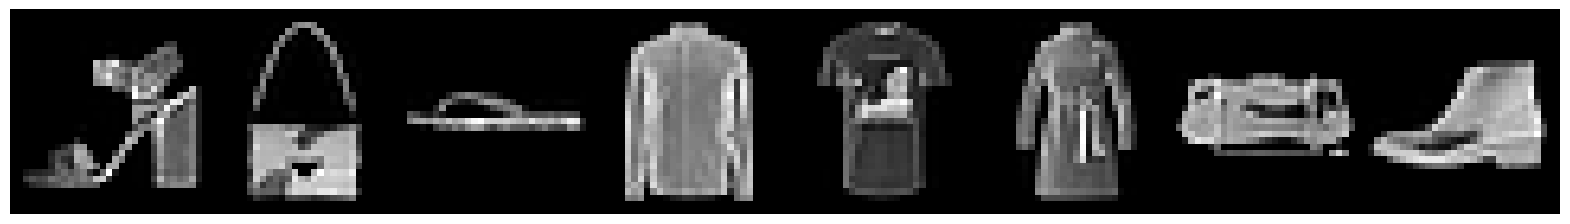

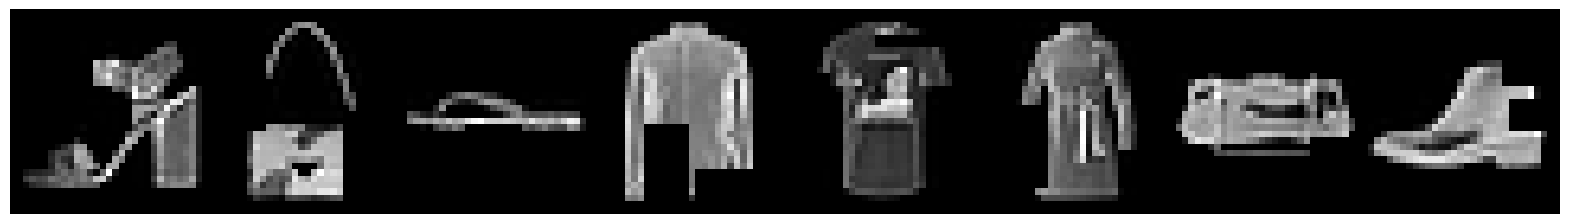

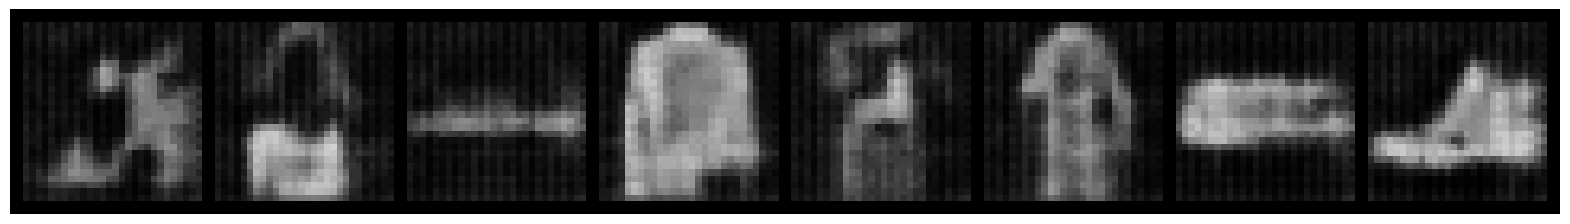

  0%|          | 0/469 [00:00<?, ?it/s]

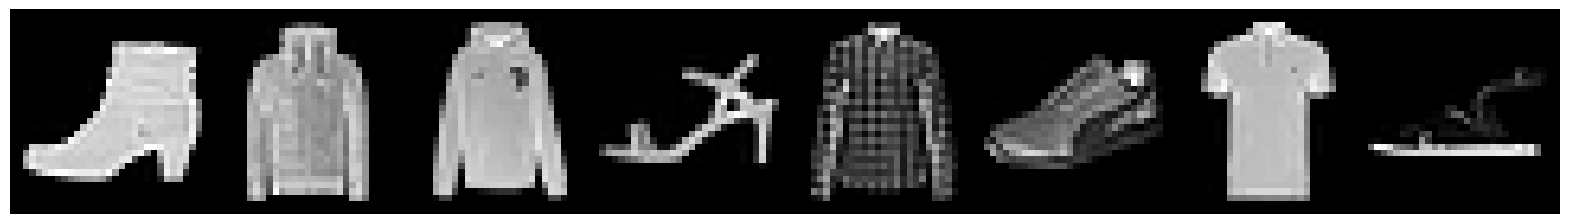

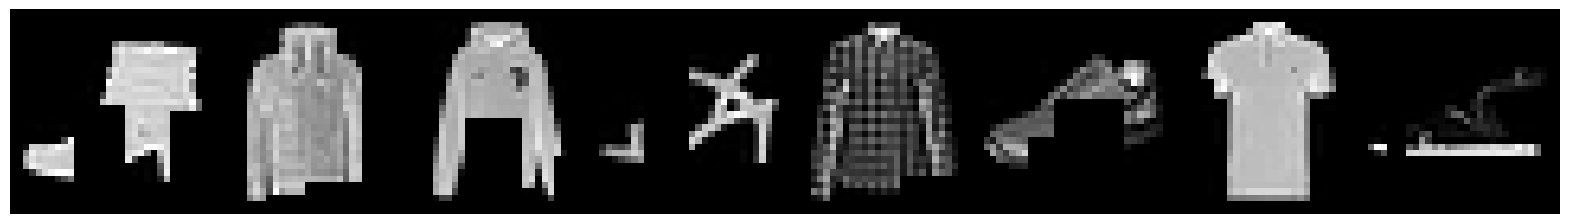

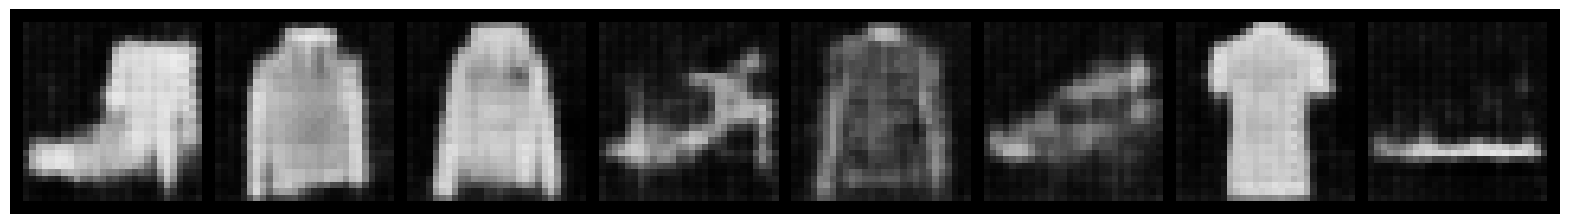

  0%|          | 0/469 [00:00<?, ?it/s]

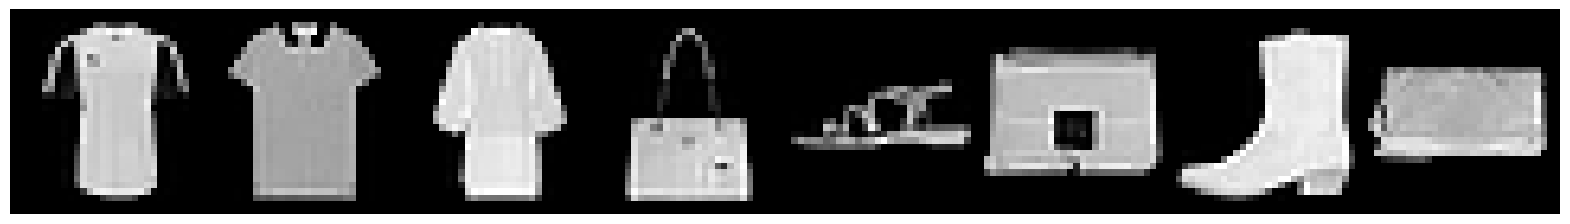

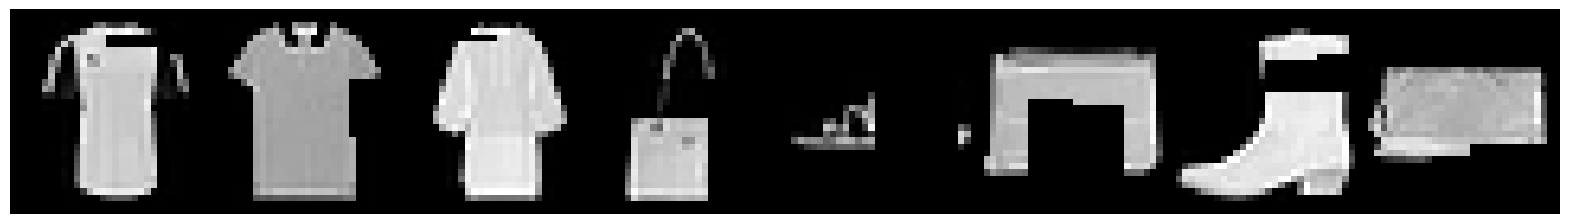

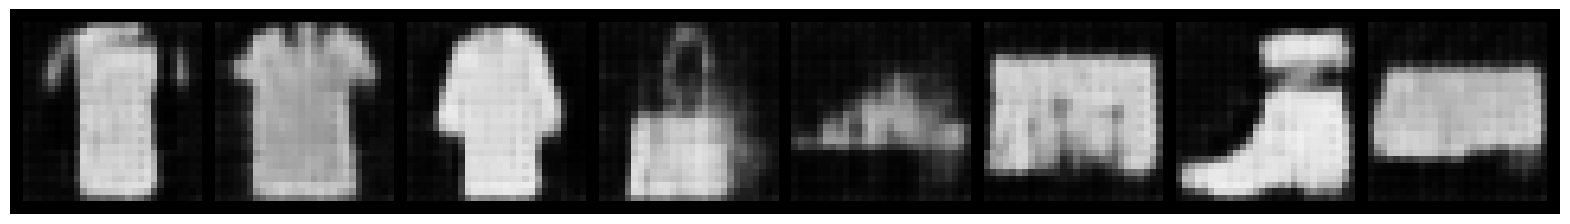

  0%|          | 0/469 [00:00<?, ?it/s]

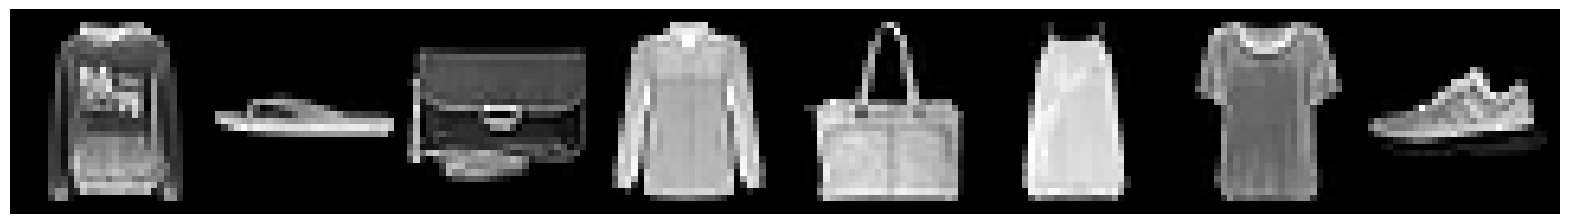

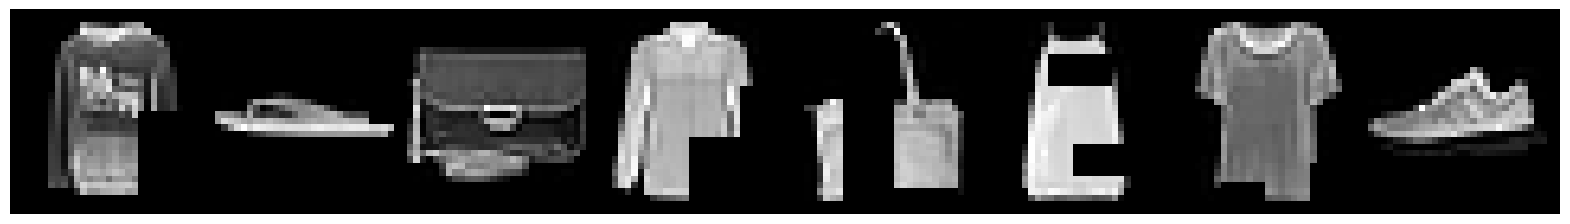

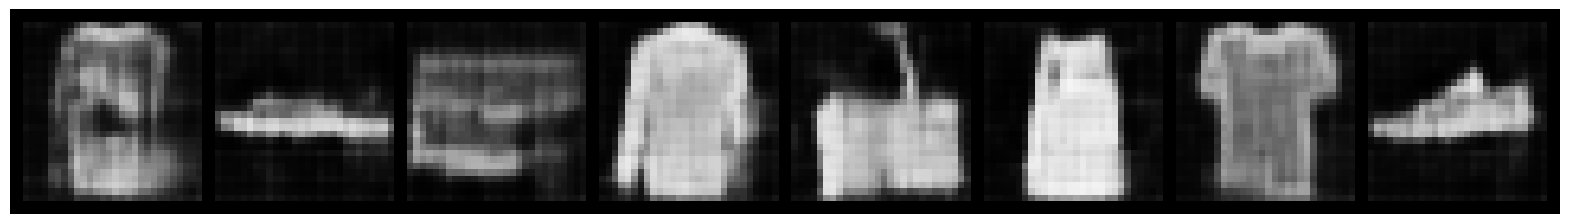

  0%|          | 0/469 [00:00<?, ?it/s]

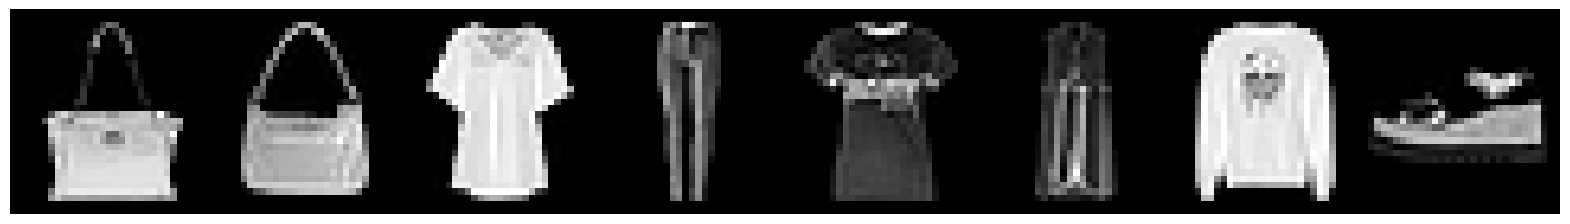

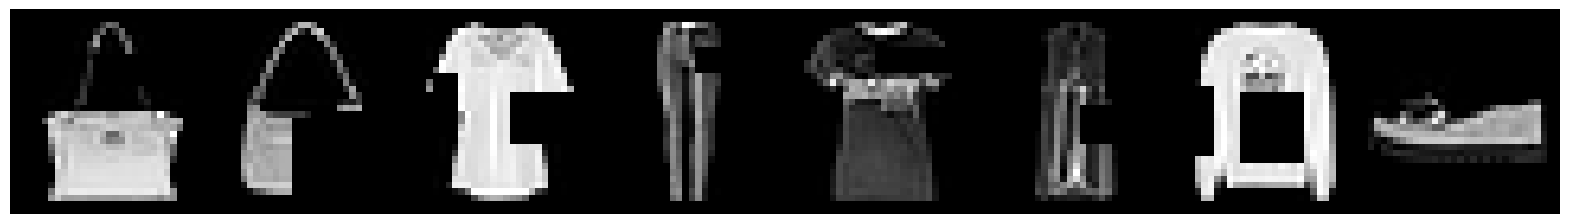

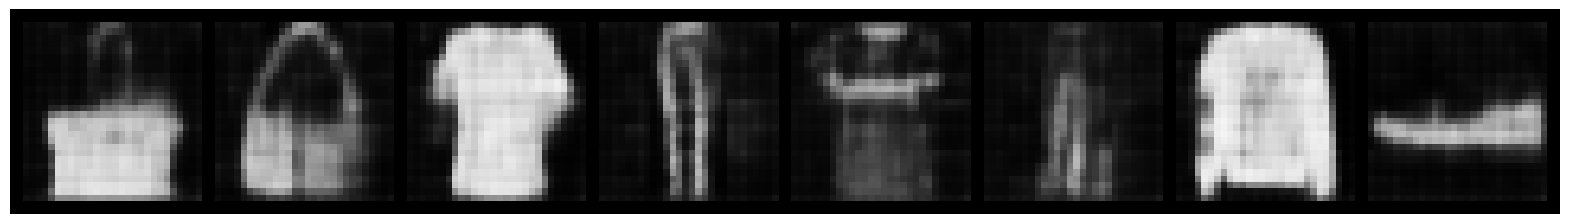

In [59]:
model = AutoEncoder().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0.001)
train_inpainting(model, optimizer, trainloader, epochs=5, min_cut=1,max_cut=27)

# Faces  
Now that we have defined all our training procedures, let's try our methods on a more detailed dataset.  
We will use the [labeled faces in the wild dataset](http://vis-www.cs.umass.edu/lfw/),  a public benchmark for face verification containing thousands of faces images.  
Run the following commands to download and extract the dataset.

In [61]:
!wget http://vis-www.cs.umass.edu/lfw/lfw.tgz > /dev/null 2>&1
!tar zxvf lfw.tgz > /dev/null 2>&1
!mkdir data > /dev/null 2>&1
!mv lfw data > /dev/null 2>&1

In [68]:
from torchvision.datasets.folder import ImageFolder

def get_faces_loader(path, **kwargs):
    process = transforms.Compose(
      [transforms.Resize((120, 120)), transforms.CenterCrop((64, 64)),transforms.ToTensor()])
    dataset = ImageFolder(path, process)
    lengths = [12000, 1233]
    train_set, val_set = torch.utils.data.random_split(dataset, lengths)
    return DataLoader(train_set, **kwargs), DataLoader(val_set, **kwargs)

trainloader, testloader = get_faces_loader(path='data/lfw',
                                    batch_size=128,
                                    shuffle=True,
                                    num_workers=2)


x, y = next(iter(trainloader))
plot_img(x[:8])
plot_img(add_noise(x[:8]))
plot_img(downscale(x[:8]))
plot_img(random_cutout(x[:8], 4, 60))

ValueError: Sum of input lengths does not equal the length of the input dataset!

## Auto-Encoder
Compared to the FashionMNIST dataset, the images of this dataset are more diverse and with a higher resolution.  
Thus using a simple auto-encoder on this dataset may not be as effective as for FashionMNIST.  
Let's try anyway to set a baseline to use a simple auto-encoder directly.  
We first need to define a new auto-encoder architecture to deal with RGB images and improve the network's capacity.

In [ ]:
class AutoEncoder(nn.Module):

    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=4, stride=2),
            nn.ReLU(True),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True)
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d( 128, 64, 4, 2, 0, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d( 64, 32, 4, 2, 1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.ConvTranspose2d( 32, 3, 4, 2, 1, bias=False),
        )

    def forward(self, x):
        z = self.encoder(x)
        y = self.decoder(z)
        return y

Verify that the defined architecture, outputs a tensor with the same dimensions as its inputs:

In [ ]:
...

In [ ]:
#@title Solution
model = AutoEncoder()
y = model(x)
print(f'Input shape: {x.shape}')
print(f'Reconstruction shape: {y.shape}')

### Denoising

Use this new architecture to train a denoising auto-encoder.

In [ ]:
...

In [ ]:
#@title Solution
model = AutoEncoder().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0.001)
train_denoising(model, optimizer, trainloader, epochs=10)

### Super-resolution
Do the same to enhance the resolution on this new datase

In [ ]:
...

In [ ]:
#@title Solution
model = AutoEncoder().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0.001)
train_upscale(model, optimizer, trainloader, epochs=10)

### Inpainting
Train your auto-encoder to fill the missing parts on this dataset.

In [ ]:
...

In [ ]:
#@title Solution
model = AutoEncoder().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0.001)
train_inpainting(model, optimizer, trainloader, epochs=10, min_cut=4, max_cut=60)

# Unet
The results may seem a little disappointing.  
This is normal, we used a very basic technique and a rather light architecture.  
A first improvement we can make to our baseline is to use an architecture more adapted to these types of problems.  
We will implement a new auto-encoder architecture called U-net.
U-net networks are auto-encoders using skips between the encoder and decoder layers.
![](https://github.com/wikistat/AI-Frameworks/blob/website/docs/img/AU_UNet.png?raw=true)

Help yourself with the image below to implement a Unet network using the following template:
![](https://drive.google.com/uc?export=view&id=1HDP2DQRAZyjGugBUkPR8svMt4kyF3p4J)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


def double_conv(in_channels, out_channels):
    # returns a block compsed of two Convolution layers with ReLU activation function
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU()
    )

class DownSampleBlock(nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv_block = double_conv(in_channels, out_channels)
        self.maxpool = nn.MaxPool2d(2)

    def forward(self, x):
        x_skip = self.conv_block(x)
        x = self.maxpool(x_skip)

        return x , x_skip

class UpSampleBlock(nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv_block = double_conv(in_channels, out_channels)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

    def forward(self, x, x_skip):
        x = self.upsample(x)
        x = torch.cat([x, x_skip], dim=1)
        x = self.conv_block(x)

        return x


class UNet(nn.Module):

    def __init__(self, in_channels=3, out_channels=3):
        super().__init__()

        self.downsample_block_1 = ...
        self.downsample_block_2 = ...

        self.middle_conv_block = ...

        self.upsample_block_2 = ...
        self.upsample_block_1 = ...

        self.last_conv = ...


    def forward(self, x):
        x, x_skip1 = ...
        x, x_skip2 = ...

        ...

        out = self.last_conv(x)

        return out

In [ ]:
#@title Solution
import torch
import torch.nn as nn
import torch.nn.functional as F


def double_conv(in_channels, out_channels):
    # returns a block compsed of two Convolution layers with ReLU activation function
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU()
    )

class DownSampleBlock(nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv_block = double_conv(in_channels, out_channels)
        self.maxpool = nn.MaxPool2d(2)

    def forward(self, x):
        x_skip = self.conv_block(x)
        x = self.maxpool(x_skip)

        return x , x_skip

class UpSampleBlock(nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv_block = double_conv(in_channels, out_channels)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

    def forward(self, x, x_skip):
        x = self.upsample(x)
        x = torch.cat([x, x_skip], dim=1)
        x = self.conv_block(x)

        return x


class UNet(nn.Module):

    def __init__(self, in_channels=3, out_channels=3):
        super().__init__()

        self.downsample_block_1 = DownSampleBlock(in_channels, 64)
        self.downsample_block_2 = DownSampleBlock(64, 128)
        self.middle_conv_block = double_conv(128, 256)


        self.upsample_block_2 = UpSampleBlock(128 + 256, 128)
        self.upsample_block_1 = UpSampleBlock(128 + 64, 64)

        self.last_conv = nn.Conv2d(64, out_channels, 1)


    def forward(self, x):
        x, x_skip1 = self.downsample_block_1(x)
        x, x_skip2 = self.downsample_block_2(x)

        x = self.middle_conv_block(x)

        x = self.upsample_block_2(x, x_skip2)
        x = self.upsample_block_1(x, x_skip1)

        out = self.last_conv(x)

        return out

Verify that the defined architecture, outputs a tensor with the same dimensions as its inputs:

In [ ]:
model = UNet()
y = model(x)
print(f'Input shape: {x.shape}')
print(f'Reconstruction shape: {y.shape}')

Train a U-Net on one of the previous tasks.

### Denoising

In [ ]:
#@title Solution
model = UNet().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0.001)
train_denoising(model, optimizer, trainloader, epochs=10)

#### Pre-trained models

In [ ]:
#The folowing cell will download the weights of pre-trained models.
# You can use it to watch the results of a model trained without having to wait for the full training
!wget https://github.com/DavidBert/INSA_notebooks/raw/main/weights.zip
!unzip weights.zip

In [ ]:
model = UNet().to(device)
model.load_state_dict(torch.load('models/unet_denoising.pth'))
x, _ = next(iter (testloader))
x_prime = add_noise(x, 0.1)
x_hat = model(x_prime.cuda())
plot_img(x[:8])
plot_img(x_prime[:8])
plot_img(torch.clip(x_hat[:8], 0, 1))

### Super-resolution

In [ ]:
#@title Solution
model = UNet().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0.001)
train_upscale(model, optimizer, trainloader, epochs=10)

In [ ]:
#@title Trained model results
model = UNet().to(device)
model.load_state_dict(torch.load('models/unet_super_resolution.pth'))
x, _ = next(iter (testloader))
x_prime = downscale(x, 2)
x_hat = model(x_prime.cuda())
plot_img(x[:8])
plot_img(x_prime[:8])
plot_img(torch.clip(x_hat[:8], 0, 1))

### Inpainting

In [ ]:
#@title Solution
model = UNet().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
train_inpainting(model, optimizer, trainloader, epochs=10, min_cut=4, max_cut=60)

In [ ]:
#@title Trained model results
model = UNet().to(device)
model.load_state_dict(torch.load('models/unet_inpainting.pth'))
x, _ = next(iter (testloader))
x_prime = random_cutout(x, 4, 60)
x_hat = model(x_prime.cuda())
plot_img(x[:8])
plot_img(x_prime[:8])
plot_img(torch.clip(x_hat[:8], 0, 1))

# PixelShuffle

The [Real-Time Single Image and Video Super-Resolution Using an EfficientSub-Pixel Convolutional Neural Network](https://arxiv.org/pdf/1609.05158.pdf) paper introduced an original and efficient upscaling layer known as __Pixel shuffle layer__.
It introduces a sub-pixel convolution taking into account pixels from different channels of the low-resolution feature map to output the upscaled high-resolution outputs.  
![](https://i.stack.imgur.com/bMcYK.png)
Its principle and intuition is described in detail in [this complementary material](https://arxiv.org/pdf/1609.07009.pdf) provided by the authors.  

The Pixel Shuffle layer is already implmented in Pytorch (https://pytorch.org/docs/stable/generated/torch.nn.PixelShuffle.html).

The original paper does not use an auto-encoder to produce high-resolution images but only a simple convolutional network with a final Pixel Shuffle layer at the outputs.  
For sake of simplicity and to speed up the computation we will also use it a a simple network, but it could be associated to a U-Net without any difficulty.

In [ ]:
class SubPixelNetwork(nn.Module):
    def __init__(self, upscale_factor):
        super(SubPixelNetwork, self).__init__()

        self.relu = nn.ReLU()
        self.conv1 = nn.Conv2d(3, 64, (5, 5), (1, 1), (2, 2))
        self.conv2 = nn.Conv2d(64, 64, (3, 3), (1, 1), (1, 1))
        self.conv3 = nn.Conv2d(64, 32, (3, 3), (1, 1), (1, 1))
        self.conv4 = nn.Conv2d(32, (upscale_factor ** 2)*3, (3, 3), (1, 1), (1, 1))
        # Sub-pixel convolution: rearranges elements in a Tensor of shape (*, r^2C, H, W)
        # to a tensor of shape (C, rH, rW)
        self.pixel_shuffle = nn.PixelShuffle(upscale_factor)


    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.pixel_shuffle(self.conv4(x))
        return x

In [ ]:
model = SubPixelNetwork(2).cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0.001)
train_upscale(model, optimizer, trainloader, epochs=10, upscale=False)

In [ ]:
#@title Trained model results
model = SubPixelNetwork(2).cuda()
model.load_state_dict(torch.load('models/pixel_shuffle.pth'))
x, _ = next(iter (testloader))
x_prime = downscale(x, 2, False)
x_hat = model(x_prime.cuda())
plot_img(x[:8])
plot_img(x_prime[:8])
plot_img(torch.clip(x_hat[:8], 0, 1))

# Partial Convolutions

The [Image Inpainting for Irregular Holes using Partial Convolutions paper](https://arxiv.org/abs/1804.07723) introduced an original convolutional layer to deal with the missing parts of image inpainting problems.   
They proposed the use of __partial convolutions__, where the convolution is masked and renormalized to be conditioned on only valid pixels.  
Partial convolution layers will thus partially apply a convolution on the inputs according to a binary mask image representing the valid and missing pixels.  

The partial convolution is computed according to the following formula:  

![](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRSitPJGC7FpseNJC4h5WeEnQadbQOwFI1Bag&usqp=CAU)  
![](https://t1.daumcdn.net/cfile/tistory/99954B335F4E638E2D)

In addition to the produced output, partial convolutions propagate the updated binary mask to the following layers.  
If the convolution was able to condition its output on at least one valid input, then the mask is removed at that location.  
The result of this is that with a sufficiently deep network, the mask will eventually be all ones (i.e. disappear).
![](https://drive.google.com/uc?export=view&id=1Gody9BVYBNUsXsLttYk37f8cB82FA_-0)


We will use [Nvidia's official implementation](https://github.com/NVIDIA/partialconv/blob/master/models/partialconv2d.py) of Partial convolution.  
Do not necessarily pay attention to implementation details. Just remember that these layers have an additional element in the forward function: they take as input an additional mask and produce as output the result of the partial convolution and the updated mask.

In [ ]:
###############################################################################
# BSD 3-Clause License
#
# Copyright (c) 2018, NVIDIA CORPORATION. All rights reserved.
#
# Author & Contact: Guilin Liu (guilinl@nvidia.com)
###############################################################################
import torch
import torch.nn.functional as F
from torch import nn, cuda
from torch.autograd import Variable

class PartialConv2d(nn.Conv2d):
    def __init__(self, *args, **kwargs):

        # whether the mask is multi-channel or not
        if 'multi_channel' in kwargs:
            self.multi_channel = kwargs['multi_channel']
            kwargs.pop('multi_channel')
        else:
            self.multi_channel = False

        if 'return_mask' in kwargs:
            self.return_mask = kwargs['return_mask']
            kwargs.pop('return_mask')
        else:
            self.return_mask = False

        super(PartialConv2d, self).__init__(*args, **kwargs)

        if self.multi_channel:
            self.weight_maskUpdater = torch.ones(self.out_channels, self.in_channels, self.kernel_size[0], self.kernel_size[1])
        else:
            self.weight_maskUpdater = torch.ones(1, 1, self.kernel_size[0], self.kernel_size[1])

        self.slide_winsize = self.weight_maskUpdater.shape[1] * self.weight_maskUpdater.shape[2] * self.weight_maskUpdater.shape[3]

        self.last_size = (None, None, None, None)
        self.update_mask = None
        self.mask_ratio = None

    def forward(self, input, mask_in=None):
        assert len(input.shape) == 4
        if mask_in is not None or self.last_size != tuple(input.shape):
            self.last_size = tuple(input.shape)

            with torch.no_grad():
                if self.weight_maskUpdater.type() != input.type():
                    self.weight_maskUpdater = self.weight_maskUpdater.to(input)

                if mask_in is None:
                    # if mask is not provided, create a mask
                    if self.multi_channel:
                        mask = torch.ones(input.data.shape[0], input.data.shape[1], input.data.shape[2], input.data.shape[3]).to(input)
                    else:
                        mask = torch.ones(1, 1, input.data.shape[2], input.data.shape[3]).to(input)
                else:
                    mask = mask_in

                self.update_mask = F.conv2d(mask, self.weight_maskUpdater, bias=None, stride=self.stride, padding=self.padding, dilation=self.dilation, groups=1)

                # for mixed precision training, change 1e-8 to 1e-6
                self.mask_ratio = self.slide_winsize/(self.update_mask + 1e-8)
                # self.mask_ratio = torch.max(self.update_mask)/(self.update_mask + 1e-8)
                self.update_mask = torch.clamp(self.update_mask, 0, 1)
                self.mask_ratio = torch.mul(self.mask_ratio, self.update_mask)


        raw_out = super(PartialConv2d, self).forward(torch.mul(input, mask) if mask_in is not None else input)

        if self.bias is not None:
            bias_view = self.bias.view(1, self.out_channels, 1, 1)
            output = torch.mul(raw_out - bias_view, self.mask_ratio) + bias_view
            output = torch.mul(output, self.update_mask)
        else:
            output = torch.mul(raw_out, self.mask_ratio)


        if self.return_mask:
            return output, self.update_mask
        else:
            return output

The authors use in their paper a U-Net whose convolutions are replaced by partial convolutions.  
The masks are thus sent to the following layers but also to the decoder layers through skip connections.

![](http://joshpatel.ca/images/Image-Inpainting/unet.jpg)
Source(http://joshpatel.ca/image_inpainting)

Modify our previous U-Net architecture to use partial convolutions.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv1 = PartialConv2d(..., return_mask=True)
        self.conv2 = PartialConv2d(..., return_mask=True)
        self.activtion = nn.ReLU()


    def forward(self, x, m):
        x, m = ...
        x = self.activtion(x)
        x, m = ...
        x = self.activtion(x)
        return x, m



class DownSampleBlock(nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv_block = ...
        self.maxpool = ...

    def forward(self, x, m):
        x_skip, m_skip = ...
        x = ...
        m = ...

        return x, m , x_skip, m_skip

class UpSampleBlock(nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv_block = ...
        self.upsample = ...

    def forward(self, x, m, x_skip, m_skip):
        x = ...
        m = ...
        x = ...
        x, m = ...

        return x, m


class UNet(nn.Module):

    def __init__(self):
        super().__init__()

        self.downsample_block_1 = ...
        self.downsample_block_2 = ...
        self.middle_conv_block = ...


        self.upsample_block_2 = ...
        self.upsample_block_1 = ...

        self.last_conv = ...


    def forward(self, x):
        #Generate mask
        m = ((x[:,:1] != 0)*1.)

        x, m, x_skip1, m_skip1 = ...
        x, m, x_skip2, m_skip2 = ...

        x, m = ...

        x, m = ...
        x, m = ...

        out = ...

        return out

In [ ]:
#@title Solution
import torch
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv1 = PartialConv2d(in_channels, out_channels, 3, padding=1, return_mask=True)
        self.conv2 = PartialConv2d(out_channels, out_channels, 3, padding=1, return_mask=True)
        self.activtion = nn.ReLU()

    def forward(self, x, m):
        x, m = self.conv1(x, m)
        x = self.activtion(x)
        x, m = self.conv2(x, m)
        x = self.activtion(x)
        return x, m



class DownSampleBlock(nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv_block = DoubleConv(in_channels, out_channels)
        self.maxpool = nn.MaxPool2d(2)

    def forward(self, x, m):
        x_skip, m_skip = self.conv_block(x, m)
        x = self.maxpool(x_skip)
        m = self.maxpool(m)

        return x, m , x_skip, m_skip

class UpSampleBlock(nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv_block = DoubleConv(in_channels, out_channels)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

    def forward(self, x, m, x_skip, m_skip):
        x = self.upsample(x)
        m = self.upsample(m)
        x = torch.cat([x, x_skip], dim=1)
#        m = torch.cat([m, m_skip], dim=1)
        x, m = self.conv_block(x, m)

        return x, m


class UNet(nn.Module):

    def __init__(self):
        super().__init__()

        self.downsample_block_1 = DownSampleBlock(3, 64)
        self.downsample_block_2 = DownSampleBlock(64, 128)
        self.middle_conv_block = DoubleConv(128, 256)


        self.upsample_block_2 = UpSampleBlock(128 + 256, 128)
        self.upsample_block_1 = UpSampleBlock(128 + 64, 64)

        self.last_conv = nn.Conv2d(64, 3, 1)


    def forward(self, x):
        #Generate mask
        m = ((x[:,:1] != 0)*1.)

        x, m, x_skip1, m_skip1 = self.downsample_block_1(x, m)
        x, m, x_skip2, m_skip2 = self.downsample_block_2(x, m)

        x, m = self.middle_conv_block(x, m)

        x, m = self.upsample_block_2(x, m, x_skip2, m_skip2)
        x, m = self.upsample_block_1(x, m, x_skip1, m_skip1)

        out = self.last_conv(x)

        return out

Verify that the defined architecture, outputs a tensor with the same dimensions as its inputs:

In [ ]:
model = UNet()
y = model(x)
print(f'Input shape: {x.shape}')
print(f'Reconstruction shape: {y.shape}')

In the article the authors separate the loss of reconstruction into two parts, one on the missing parts of the image and the other on its complement.  
This allows them to weight the importance given to each of these terms.  
For the sake of simplicity, we will continue to use a single global loss for training.  
Use your implementtaion of U-Net with partial convolutions to train a new network to fill the missing parts of the image.

In [ ]:
model = UNet().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
train_inpainting(model, optimizer, trainloader, epochs=5, min_cut=4, max_cut=60)

In [ ]:
#@title Trained model results
model = UNet().to(device)
model.load_state_dict(torch.load('models/partial_conv.pth'))
x, _ = next(iter (testloader))
x_prime = random_cutout(x, 4, 60)
x_hat = model(x_prime.cuda())
plot_img(x[:8])
plot_img(x_prime[:8])
plot_img(torch.clip(x_hat[:8], 0, 1))

# Losses
## L1 loss
So far, we have used a Mean Squared Error Loss to compute the pixel differences between our prediction and the desired images.  
Minimizing the mean per-pixel squared difference may result in blurry images.  
The problem is in the shape of the loss as it approaches zero. The closer the error is to zero, the smaller the gradient is, meaning that a slight deviation from the ground truth necessary for sharpness is not penalized as much.
An alternative consists in using an L1 distance instead, which has constant gradients that could lead to sharper-looking images.

## Perceptual losses
Recently, a new category off loss functions from the style transfer community has been combined with other super-resolution techniques, leading to significantly improved output image quality.  
In particular, the __Perceptual Losses__, introduced in [Perceptual Losses for Real-Time Style Transfer and Super-Resolution](https://arxiv.org/abs/1603.08155) consists in VGG network pre-trained for image classification to minimize two terms:
* a __content loss__ consisting in the L2 difference between the features of the produced image and the reference image when passed trough the pre-trained network. The intuition behind this loss is to preserve a similar high-level feature representation leading to better semantic correctness of the completion.

* a __style loss__ consisting in the L2 difference the auto-correlations of the feature maps also computed with the pre-trained network.  The auto-correlations are represented by [Gram Matrices](https://en.wikipedia.org/wiki/Gram_matrix) and are supposed to contain the style information of an image such as textures and colours.

![](https://images.deepai.org/django-summernote/2019-06-16/54b7a304-efa9-46fb-8034-c750dcd98c99.png)  

The following code implements a network that outputs 4 groups of features of a pre-trained VGG16 and a function computing the perceptual losses.

In [ ]:
import torchvision.models as models

def gram_matrix(input):
    a, b, c, d = input.size()   # a=batch size(=1)
                                # b=number of feature maps
                                # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)
    G = torch.mm(features, features.t())  # compute the gram product
    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

class LossNetwork(torch.nn.Module):
    def __init__(self):
        super(LossNetwork, self).__init__()
        vgg_model = models.vgg16(pretrained=True).to(device).eval()
        self.vgg_layers = vgg_model.features
        self.layer_name_mapping = {
            '3': "relu1_2",
            '8': "relu2_2",
            '15': "relu3_3",
            '22': "relu4_3"
        }

    def forward(self, x):
        features = []
        for name, module in self.vgg_layers._modules.items():
            x = module(x)
            if name in self.layer_name_mapping:
                features.append(x)
        return features


loss_network = LossNetwork()

def perceptual_loss(x, y):
    mse = torch.nn.MSELoss()
    x_feats = loss_network(x)
    y_feats = loss_network(y)
    #content loss:
    loss = mse(x_feats[2], y_feats[2].detach())
    #style loss:
    for feats, target_feats in zip(x_feats, y_feats):
        loss += mse(gram_matrix(feats), gram_matrix(target_feats.detach()))
    return loss

## Total variation loss

To encourage the smoothness of the completed images, a regularization term called __total variation loss__ is often added to the final objective function.
This loss is commonly used in the signal processing community as a noise removal process (filter).
It simply consists in computing the sum of the absolute differences for neighboring pixel-values in the input images.  

In [ ]:
def total_variation_loss(x):
    loss = torch.mean(torch.abs(x[:, :, :, :-1] - x[:, :, :, 1:])) + \
            torch.mean(torch.abs(x[:, :, :-1, :] - x[:, :, 1:, :]))
    return torch.mean(loss)

Modify the ```train_upscale``` and the ```train_inpainting``` methods to use a L1 loss instead of the MSE and to incorporate the perceptual and total variation losses.  
Train a Subpixel Network to improve the images quality and a Unet with partial convolution to fill the missed parts of images using these enhanced training loop.

In [ ]:
def train_upscale(net, optimizer, loader, epochs=5, scale_factor=2, upscale=True):
    ...

In [ ]:
#@title Solution
def train_upscale(net, optimizer, loader, epochs=5, scale_factor=2, upscale=True):
    criterion = torch.nn.L1Loss()
    for epoch in range(epochs):
        running_loss = []
        t = tqdm(loader)
        for x, _ in t:
            x = x.to(device)
            x_low_res = downscale(x, scale_factor, upscale)
            outputs = net(x_low_res)
            loss = criterion(outputs, x) + perceptual_loss(outputs, x) + total_variation_loss(outputs)
            running_loss.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            t.set_description(f'training loss: {mean(running_loss)}')
        plot_img(x[:8])
        plot_img(x_low_res[:8])
        plot_img(torch.clip(outputs[:8], 0, 1))

In [ ]:
def train_inpainting(net, optimizer, loader, epochs=5, min_cut=15,max_cut=45):
    ...

In [ ]:
#@title Solution
def train_inpainting(net, optimizer, loader, epochs=5, min_cut=15,max_cut=45):
    criterion = torch.nn.L1Loss()
    for epoch in range(epochs):
        running_loss = []
        t = tqdm(loader)
        for x, _ in t:
            x = x.to(device)
            x_co = random_cutout(x, min_cut, max_cut)
            outputs = net(x_co)
            loss = criterion(outputs, x) + perceptual_loss(outputs, x) + total_variation_loss(outputs)
            running_loss.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            t.set_description(f'training loss: {mean(running_loss)}')
        plot_img(x[:8])
        plot_img(x_co[:8])
        plot_img(torch.clip(outputs[:8], 0, 1))

In [ ]:
#Since we use a separate pre-trained network to compute our perceptual losses, the whole training loop uses more GPU memory.
#We need to reduce the batch size to fit in the GPU memory.
trainloader, testloader = get_faces_loader(path='data/lfw',
                                    batch_size=32,
                                    shuffle=True,
                                    num_workers=2)

model = SubPixelNetwork(2).cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0.001)
train_upscale(model, optimizer, trainloader, epochs=10, upscale=False)

In [ ]:
#@title Trained model results
model = SubPixelNetwork(2).cuda()
model.load_state_dict(torch.load('models/super_res_all_losses.pth'))
x, _ = next(iter (testloader))
x_prime = downscale(x, 2, False)
x_hat = model(x_prime.cuda())
plot_img(x[:8])
plot_img(x_prime[:8])
plot_img(torch.clip(x_hat[:8], 0, 1))

In [ ]:
#Since we use a separate pre-trained network to compute our perceptual losses, the whole training loop uses more GPU memory.
#We need to reduce the batch size to fit in the GPU memory.
trainloader, testloader = get_faces_loader(path='data/lfw',
                                    batch_size=32,
                                    shuffle=True,
                                    num_workers=2)
model = UNet().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
train_inpainting(model, optimizer, trainloader, epochs=10, min_cut=4, max_cut=50)

In [ ]:
#@title Trained model results
model = UNet().to(device)
model.load_state_dict(torch.load('models/inpainting_all_losses.pth'))
x, _ = next(iter (testloader))
x_prime = random_cutout(x, 4, 60)
x_hat = model(x_prime.cuda())
plot_img(x[:8])
plot_img(x_prime[:8])
plot_img(torch.clip(x_hat[:8], 0, 1))

# Combining inpainting and super-resolution

Finally, it is also possible to improve the prediction of an inpating network by using a super-resolution network.  
In general the inpating network is trained separately and fine tuned during the training of the super-resolution network.

In [ ]:
def train_impate_upscale(impainter, augmeter, optimizer, loader, epochs=5, min_cut=15,max_cut=45):
    criterion = torch.nn.L1Loss()
    for epoch in range(epochs):
        running_loss = []
        t = tqdm(loader)
        for x, _ in t:
            x = x.to(device)
            x_co = random_cutout(x, min_cut, max_cut)
            outputs = impainter(x_co)
            outputs = augmeter(outputs)
            loss = criterion(outputs, x) + perceptual_loss(outputs, x) + total_variation_loss(outputs)
            running_loss.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            t.set_description(f'training loss: {mean(running_loss)}')
        plot_img(x[:8])
        plot_img(x_co[:8])
        plot_img(torch.clip(outputs[:8], 0, 1))

In [ ]:
augmeter = SubPixelNetwork(1).cuda()
optimizer = torch.optim.Adam(augmeter.parameters(), lr=1e-3, weight_decay=0.001)
train_upscale(augmeter, optimizer, trainloader, epochs=10)

In [ ]:
inpainter = model
#params = list(inpainter.parameters()) + list(augmeter.parameters())

#optimizer = torch.optim.Adam(params, lr=1e-5, weight_decay=0.001)
#augmeter = SubPixelNetwork(1).cuda()
optimizer = torch.optim.Adam(augmeter.parameters(), lr=1e-3, weight_decay=0.001)
train_impate_upscale(inpainter, augmeter, optimizer, trainloader, epochs=10)

In [ ]:
#@title Trained model results
augmenter = SubPixelNetwork(1).cuda()
augmenter.load_state_dict(torch.load('models/augmenter.pth'))
inpainter = UNet().cuda()
inpainter.load_state_dict(torch.load('models/inpainter.pth'))
x, _ = next(iter (testloader))
x_prime = random_cutout(x, 4, 60)
x_hat = augmenter(inpainter(x_prime.cuda()))
plot_img(x[:8])
plot_img(x_prime[:8])
plot_img(torch.clip(x_hat[:8], 0, 1))

# Optional: GAN
We have seen that different loss functions allow to minimize the difference in perception between the generated image and the original image.  
There is an infinite number of solutions to fill the missing parts of the images. The important thing is that the filled part seems visually coherent.  
To do this, one can use a separate neural network that has been trained to recognize real images from fake ones.
This approach, better known as Generative Adverserial Networks (GAN) has been used in inpainting in [Context Encoders: Feature Learning by Inpainting](https://arxiv.org/abs/1604.07379) to improve the prediction of an auto-encoder.  
The auto-encoder then plays the role of generator and is trained to fill in the missing parts using a reconstruction loss but also a signal provided by a discriminator able to train to discern the true images from the false ones.
In this way, the missing parts of the image are constructed by the generator to produce plausible pieces.

In [ ]:
from torchvision.datasets.folder import ImageFolder

def get_super_resolution_loader(path, **kwargs):
    process = transforms.Compose(
      [transforms.Resize((120, 120)), transforms.CenterCrop((64, 64)),transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    dataset = ImageFolder(path, process)
    lengths = [12000, 1233]
    train_set, val_set = torch.utils.data.random_split(dataset, lengths)
    return DataLoader(train_set, **kwargs), DataLoader(val_set, **kwargs)


transform = transforms.Compose(
              [transforms.Resize((120, 120)),
               transforms.CenterCrop((64, 64)),
               transforms.ToTensor(),
               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

dataset = ImageFolder('data/lfw', transform)
trainloader =  DataLoader(dataset, batch_size=128, shuffle=True, num_workers=2)

inv_normalize = transforms.Normalize(
   mean= [-m/s for m, s in zip((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))],
   std= [1/s for s in (0.5, 0.5, 0.5)]
)

In [ ]:
generator = nn.Sequential(UNet(), nn.Tanh()).to(device)

discriminator = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        ).to(device)



def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

discriminator.apply(weights_init);
generator.apply(weights_init);

In [ ]:
criterion = nn.BCELoss()

real_label = 0.9
fake_label = 0.

# Setup Adam optimizers for both G and D
lr = 0.001
beta1 = 0.5
optimizerD = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizerG = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

In [ ]:
def update_discriminator(discriminator, optimizer, x, fake, real_label=1, fake_label=0):
    discriminator.zero_grad()
    b_size = x.size(0)
    label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
    # Forward pass real batch through D
    output = discriminator(x).view(-1)
    # Calculate loss on all-real batch
    loss = criterion(output, label)
    D_x = output.mean().item()
    label = torch.full((b_size,), fake_label, dtype=torch.float, device=device)
    # Classify all fake batch with D
    output = discriminator(fake.detach()).view(-1)
    # Calculate D's loss on the all-fake batch
    loss += criterion(output, label)
    D_G_z1 = output.mean().item()
    loss.backward()
    optimizer.step()
    return loss, D_x, D_G_z1

def update_generatot(generator, discriminator, optimizer, x, fake, real_label=1):
    generator.zero_grad()
    b_size = fake.size(0)
    label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
    output = discriminator(fake).view(-1)
    loss = nn.BCELoss()(output, label) + torch.nn.L1Loss()(fake, x)
    loss.backward()
    D_G_z2 = output.mean().item()
    optimizer.step()
    return loss, D_G_z2

In [ ]:
def train_context_encoder(generator, discriminator, optimizerG, optimizerD, loader, epochs=10, real_label=0.9, fake_label=0):
    for epoch in range(epochs):
        t = tqdm(loader)
        for x, _ in t:
            x = x.to(device)
            ## Train with all-fake batch
            x_co = random_cutout(x, 5, 60)
            fake = generator(x_co)

        # discriminator update
            errD, D_x, D_G_z1 = update_discriminator(discriminator, optimizerD, x, fake, real_label, fake_label)
            errG, D_G_z2 = update_generatot(generator, discriminator, optimizerG, x, fake, real_label)


        print(f'epoch:{epoch}/{epochs} \tLoss_D:{errD.item():.4f} \tLoss_G:{errG.item():.4f} \tD(x):{D_x:.4f} \tD(G(z)):{D_G_z1:.4f} / {D_G_z2:.4f}')
        plot_img(inv_normalize(x[:8]))
        plot_img(inv_normalize(x_co[:8]))
        plot_img(torch.clip(inv_normalize(fake[:8]), 0, 1))

train_context_encoder(generator, discriminator, optimizerG, optimizerD, trainloader, real_label=0.9, fake_label=0)

In [ ]:
with torch.no_grad():
    x, _ = next(iter(trainloader))
    x_co = random_cutout(x, 5, 60).to(device)
    fake = generator(x_co).detach().cpu()
plot_img(inv_normalize(x[:8]))
plot_img(inv_normalize(x_co[:8]))
plot_img(torch.clip(inv_normalize(fake[:8]), 0, 1))

In [ ]:
generator


# Optional: additional methods.
## Edges prior

To further improve the quality of the inpainting results, we can provide prior information of the missing regions to the generator network to generate better local fine texture details.  
This is done in the article [EdgeConnect: Generative Image Inpainting with Adversarial Edge Learning](https://arxiv.org/pdf/1901.00212.pdf) where a generator is trained to produce the cany edges with missed regions filled.  
This edges representation is then combined with the original image and used by a second generator to produce the final output.  
![](https://miro.medium.com/max/2400/1*KKiBBWo20W2BjrzEViWVVA.png)

In [ ]:
# This code will download a cany-edges version of the dataset pre-computed  using Open CV.

!wget https://github.com/DavidBert/INSA_notebooks/raw/main/lfw_cany.zip
!unzip lfw_cany.zip

In [ ]:
  from torchvision.datasets.folder import ImageFolder, default_loader, IMG_EXTENSIONS

class ImagesAndEdges(ImageFolder):
    def __init__(
        self,
        root,
        transform=None,
        target_transform=None,
    ):
        super(ImageFolder, self).__init__(
            root=root,
            loader=default_loader,
            transform=transform,
            extensions=IMG_EXTENSIONS,
        )


    def __getitem__(self, index):
        path, _ = self.samples[index]
        cany_path = path.replace("lfw", "lfw_cany")
        sample = self.loader(path)
        cany_sample = self.loader(cany_path)
        if self.transform is not None:
            sample = self.transform(sample)
            cany_sample = self.transform(cany_sample)
        #cany_sample = cany_sample.mean(0).unsqueeze(0)
        return sample, cany_sample

def get_images_and_edges_loader(path, **kwargs):
  process = transforms.Compose(
      [transforms.Resize((120, 120)), transforms.CenterCrop((64, 64)),transforms.ToTensor()])
  dataset = ImagesAndEdges(path, process)
  lengths = [12000, 1233]
  train_set, val_set = torch.utils.data.random_split(dataset, lengths)
  return DataLoader(train_set, **kwargs), DataLoader(val_set, **kwargs)

trainloader, testloader = get_images_and_edges_loader(path='data/lfw',
                                    batch_size=128,
                                    shuffle=True,
                                    num_workers=2)


x, y = next(iter(trainloader))
plot_img(x[:8])
plot_img(y[:8])
plot_img(add_noise(x[:8]))
plot_img(add_noise(y[:8]))
plot_img(downscale(x[:8]))
plot_img(downscale(y[:8]))
x_co = random_cutout(x, 4, 60)
plot_img(x_co[:8])
y_co = y * (x_co[:,:1] != 0)*1.
plot_img(y_co[:8])


The paper uses GANs to train both generators.  
Let's first train the edge network:

In [ ]:
edge_generator = nn.Sequential(UNet(in_channels=3, out_channels=1).cuda(), nn.Tanh()).to(device)

discriminator = nn.Sequential(
            nn.Conv2d(1, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        ).to(device)


discriminator.apply(weights_init);
edge_generator.apply(weights_init);

In [ ]:
criterion = nn.BCELoss()

real_label = 0.9
fake_label = 0.

# Setup Adam optimizers for both G and D
lr = 0.001
beta1 = 0.5
optimizerD = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizerG = torch.optim.Adam(edge_generator.parameters(), lr=lr, betas=(0.5, 0.999))

In [ ]:
def train_context_encoder_edges(generator, discriminator, optimizerG, optimizerD, loader, epochs=10, real_label=0.9, fake_label=0, show_images=True):
    for epoch in range(epochs):
        t = tqdm(loader)
        for x, y in t:
            x = x.to(device)
            y = y.to(device)
            ## Train with all-fake batch
            x_co = random_cutout(x, 5, 60)
            fake = generator(x_co)

                    # discriminator update
            errD, D_x, D_G_z1 = update_discriminator(discriminator, optimizerD, y, fake, real_label, fake_label)
            errG, D_G_z2 = update_generatot(generator, discriminator, optimizerG, y, fake, real_label)


        print(f'epoch:{epoch}/{epochs} \tLoss_D:{errD.item():.4f} \tLoss_G:{errG.item():.4f} \tD(x):{D_x:.4f} \tD(G(z)):{D_G_z1:.4f} / {D_G_z2:.4f}')
        if show_images:
            plot_img(x[:8])
            plot_img(x_co[:8])
            plot_img(y[:8])
            plot_img(torch.clip(fake[:8], 0, 1))

train_context_encoder_edges(edge_generator, discriminator, optimizerG, optimizerD, trainloader, epochs=3, real_label=0.9, fake_label=0)

#train_context_encoder_edges(edge_generator, discriminator, optimizerG, optimizerD, trainloader, epochs=50, real_label=0.9, fake_label=0, show_images=False)
#torch.save(edge_generator.state_dict(), 'models/edge_generator.pth')

We can now train the final model:

In [ ]:
generator = nn.Sequential(UNet(in_channels=4, out_channels=3).cuda(), nn.Tanh()).to(device)

discriminator = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        ).to(device)


discriminator.apply(weights_init);
generator.apply(weights_init);
optimizerD = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizerG = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

class EdgeConnectModel(nn.Module):

    def __init__(self, edge_generator, generator):
        super().__init__()
        self.edge_generator = edge_generator
        self.generator = generator

    def forward(self, x):
        with torch.no_grad():
            edges = self.edge_generator(x)
        x = torch.cat([x, edges.detach()], dim=1)
        y = self.generator(x)
        return y, edges

model = EdgeConnectModel(edge_generator, generator)

In [ ]:
def train_edge_connect_model(generator, discriminator, optimizerG, optimizerD, loader, epochs=10, real_label=0.9, fake_label=0, show_images=True):
    for epoch in range(epochs):
        t = tqdm(loader)
        for x, _ in t:
            x = x.to(device)
            ## Train with all-fake batch
            x_co = random_cutout(x, 5, 60)
            fake, edges = generator(x_co)

                    # discriminator update
            errD, D_x, D_G_z1 = update_discriminator(discriminator, optimizerD, x, fake, real_label, fake_label)
            errG, D_G_z2 = update_generatot(generator, discriminator, optimizerG, x, fake, real_label)


        print(f'epoch:{epoch}/{epochs} \tLoss_D:{errD.item():.4f} \tLoss_G:{errG.item():.4f} \tD(x):{D_x:.4f} \tD(G(z)):{D_G_z1:.4f} / {D_G_z2:.4f}')
        if show_images:
            plot_img(x[:8])
            plot_img(x_co[:8])
            plot_img(edges[:8])
            plot_img(torch.clip(fake[:8], 0, 1))

train_edge_connect_model(model, discriminator, optimizerG, optimizerD, trainloader, epochs=3, real_label=0.9, fake_label=0)

#train_edge_connect_model(model, discriminator, optimizerG, optimizerD, trainloader, epochs=50, real_label=0.9, fake_label=0, show_images=False)
#torch.save(model.state_dict(), 'models/edge_connect_model.pth')

In [ ]:
model.load_state_dict(torch.load('models/edge_connect_model.pth'))
with torch.no_grad():
    x, _ = next(iter (testloader))
    x_prime = random_cutout(x, 4, 60)
    x_hat, edges = model(x_prime.cuda())
plot_img(x[:8])
plot_img(x_prime[:8])
plot_img(edges[:8])
plot_img(x_hat[:8])